# Importing Necessary Libraries

In [1]:
%matplotlib notebook

import math
import time
from collections import deque

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# Load up the data
## Natural gas prices dataset
Time series of major Natural Gas Prices including US Henry Hub. Data comes from U.S. Energy Information Administration [EIA](http://www.eia.gov/)
<br>Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to 2018. Prices are in nominal dollars.
<br>You can find the data [here](https://datahub.io/core/natural-gas)

In [2]:
gas_df = pd.read_csv("natural-gas-daily_csv.csv")
gas_df.head()

,Date,Price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


Drop the date column.

In [3]:
gas_df.drop(['Date'], axis=1, inplace=True)
gas_df.head()

,Price
0,3.82
1,3.80
2,3.61
3,3.92
4,4.00


Drop Nan values.

In [4]:
print("Before dropping Nan values: ", len(gas_df))

Before dropping Nan values:  5465


In [5]:
gas_df.dropna(inplace=True)

In [6]:
print("After dropping Nan values: ", len(gas_df))

After dropping Nan values:  5464


## Plot the data

<IPython.core.display.Javascript object>


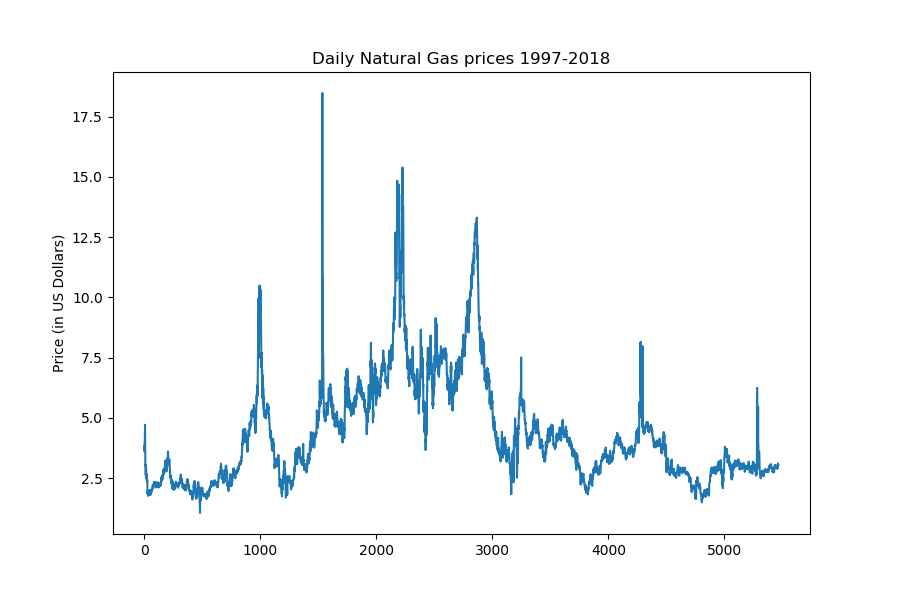

In [7]:
plt.figure(figsize=(9,6))
plt.plot(gas_df.index, gas_df)
plt.title("Daily Natural Gas prices 1997-2018")
plt.ylabel("Price (in US Dollars)")
plt.show()

# Data Preprocessing

These functions will be used to scale, generate sequences, and split our sequential data in order to prepare it for input to an LSTM Keras model.

This function is for scaling the data.
<br>**Note:** we need to scale because if we fit the model on unscaled data that has a wide range of values, then it is possible for large inputs to slow down the learning and convergence of our network and in some cases prevent the network from effectively learning your problem.

In [8]:
def scale_data(input_3d_array):
    """
    This function transforms the values of a 3D numpy array using MinMaxScaler from sklearn.model_selection
    """
    original_shape = input_3d_array.shape
    # Reshaping the the array in order to make it 2-Dimensional array
    # since fit_transform function accepts only 2D array as an input parameter.
    input_3d_array = input_3d_array.reshape(input_3d_array.shape[0],input_3d_array.shape[1])
    # Transforming the values.
    input_3d_array = min_max_scaler.fit_transform(input_3d_array)
    # Reshaping the array back to its original shape.
    input_3d_array = input_3d_array.reshape(original_shape)
    
    return input_3d_array

This function will be used to generate input sequences which consists of (X,y) arrays, where:
<br> X : the prices of the days preceding the target day (the day that we want to predict the price for).
<br> y : the price on target day.

In [9]:
def preprocess_data(data_array, window):
    """
    This method takes a numpy array as input, and returns X,y numpy arrays as the output.
    N = len(data)
    X (data_array) = shape(N-window,window,1)
    y = shape(N-window,1)
    """
    X = []
    y = []
    SEQ_LEN = window
    # the prices of a number of squential days equal to the window parameter
    prev_days = deque(maxlen=SEQ_LEN)
    for index,item in enumerate(data_array[:-1]):
        prev_days.append(item)
        if len(prev_days) == SEQ_LEN:
            X.append(np.array(prev_days))
            y.append(data_array[index+1])
    
    return np.array(X), np.array(y)

This function will be used for splitting the data into training, testing and validation sets.

In [10]:
def split_data(X_main, y_main, split_test_and_val=0.2):
    
    """
    This function returns training, validation, and testing data based on the wanted split size. as follows:
    X_test, X_val, y_test, y_val
    The split validation and the test data are going to have size of (split_size) and the rest of the data
    is going to categorized under training
    : X_main: inputs
    : y_main: targets
    : split_size: float ex. 0.2 means 10% for testing and 10% for validation and 80% for training
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X_main, y_main, test_size=split_test_and_val)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

# Saving some input samples to test the trained models

We are going to train **6 models** in order to experiment the different resutls and pick out what is best. Concretely, these are the characteristics that we are going to build the models on:
* Save **100** input samples from the last part of the data. **(70% training data, 15% validation data,15% testing data)**
* Save **100** input samples. **(50% training, 25% validation, 25% testing)**
* Save **1000** input samples **(70% training, 15% validation, 15% testing)**
* Save **1000** input samples **(50% training, 25% validation, 25% testing)**
* Save **2000** input samples **(70% training, 15% validation, 15% testing)**
* Save **2000** input samples **(50% training, 25% validation, 25% testing)**

Using MinMaxScaler provided by Scikit-learn in order to scale the data into the range (0,1).

In [11]:
min_max_scaler = MinMaxScaler()
min_max_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

The following method will be used for creating the input and output sample arrays that are going to be used later for testing
the model:

In [12]:
def create_input_and_output_sample(df, input_sample_length, window):
    """
    This method takes a dataframe, an input sample length which is the number of days that we want to predict from the last
    part of the given dataframe, and window which is the number of consecutive days that we will look at before each day
    that we will predict.
    """
    # take the last necessary part of the dataframe
    index = input_sample_length + window
    df = df[-index:]
    # scale the data
    scaled_df = scale_data(df.values)
    # getting the input_sample and output_sample
    X, y = preprocess_data(scaled_df, window)
    
    print(f"input sample length: {input_sample_length}, window: {window}")
    print(f"Shape of X: {X.shape}, shape of y: {y.shape}")
    
    return X, y

Extract the (X,y) Numpy arrays from the last part of the data to use it to evaluate the the models.

In [13]:
X_test_sample_100, y_test_sample_100 = create_input_and_output_sample(df=gas_df, input_sample_length=100, window=10)
X_test_sample_1000, y_test_sample_1000 = create_input_and_output_sample(df=gas_df, input_sample_length=1000, window=10)
X_test_sample_2000, y_test_sample_2000 = create_input_and_output_sample(df=gas_df, input_sample_length=2000, window=10)

input sample length: 100, window: 10
Shape of X: (100, 10, 1), shape of y: (100, 1)
input sample length: 1000, window: 10
Shape of X: (1000, 10, 1), shape of y: (1000, 1)
input sample length: 2000, window: 10
Shape of X: (2000, 10, 1), shape of y: (2000, 1)


In [14]:
len(gas_df)

5464

Let's extract the data that will be used for generating sequences and fitting the model excluding the last 100, 1000, 2000 days respectively. Concretely:
<br>df_100_70 : This data frame will be used to fit (70% training, 30% testing) model with last 100 days excluded from the original data.
<br>df_100_50 : This data frame will be used to fit (50% training, 50% testing) model with last 100 days excluded from the original data.
<br>df_1000_70 : This data frame will be used to fit (70% training, 30% testing) model with last 1000 days excluded from the original data.
<br>df_1000_50 : This data frame will be used to fit (50% training, 50% testing) model with last 1000 days excluded from the original data.
<br>df_2000_70 : This data frame will be used to fit (70% training, 30% testing) model with last 2000 days excluded from the original data.
<br>df_2000_50 : This data frame will be used to fit (50% training, 50% testing) model with last 2000 days excluded from the original data.

In [15]:
df_100_70 = gas_df[:-100] # the rest of the data that we are going to use for training and testing
df_100_50 = gas_df[:-100] # the rest of the data that we are going to use for training and testing

df_1000_70 = gas_df[:-1000] # the rest of the data that we are going to use for training and testing
df_1000_50 = gas_df[:-1000] # the rest of the data that we are going to use for training and testing

df_2000_70 = gas_df[:-2000] # the rest of the data that we are going to use for training and testing
df_2000_50 = gas_df[:-2000] # the rest of the data that we are going to use for training and testing

# Scaling the data

In [16]:
scaled_data_100_70 = scale_data(df_100_70.values)
scaled_data_100_50 = scale_data(df_100_50.values)

scaled_data_1000_70 = scale_data(df_1000_70.values)
scaled_data_1000_50 = scale_data(df_1000_50.values)

scaled_data_2000_70 = scale_data(df_2000_70.values)
scaled_data_2000_50 = scale_data(df_2000_50.values)

This function will be used for generating a list of random number (between a range whose bounds set by the parameters). These numbers will be used to generate X sequences that will be provided as an input for our models.

In [17]:
def generate_random_list_of_delays(size=20,min_range=0,max_range=100):
    
    import random
    result = [random.randint(min_range, max_range) for i in range(size)]
    
    return result

In [18]:
lengths = generate_random_list_of_delays(size=30 ,min_range=5, max_range=100)
print(lengths)

[25, 34, 45, 61, 35, 24, 14, 79, 29, 90, 56, 60, 10, 34, 61, 90, 34, 38, 32, 91, 99, 26, 54, 87, 41, 93, 40, 84, 48, 57]


The following method will be used for generating all the input and output sequences as (X,y) Numpy arrays based on the random lengths generated earlier and storing each (X,y) pair in two separate lists. After that, these lists will be split into training, testing and validation, which in its turn makes up 4 lists, where:
<br>X_train_all: contains all input sequential X Numpy arrays that will be used for training.
<br>X_test_all: contains all input sequential X Numpy arrays that will be used for testing.
<br>X_val_all: contains all input sequential X Numpy arrays that will be used for validation.
<br>y_train_all: contains all output sequential y Numpy arrays that will be used for training.
<br>y_test_all: contains all output sequential y Numpy arrays that will be used for testing.
<br>y_val_all: contains all output sequential y Numpy arrays that will be used for validation.

In [19]:
def generate_input_and_target_lists(scaled_data, lengths, split_size):
    """
    This method takes a scaled pandas dataframe, a list of lengths which represents the window (or the consecutive days) that
    the model is going to use in order to the preidct the next day, and the test size split. It returns the following four 
    lists (each one of these lists is based on its corresponding length of the list of lengths.):
    (X_train_all, X_test_all, y_train_all, y_test_all)
    """
    
    
    X_lists = []
    y_lists = []

    X_train_all = []
    X_test_all = []
    X_val_all = []

    y_train_all = []
    y_test_all = []
    y_val_all = []

    for length in lengths:
    
        X, y = preprocess_data(scaled_data, window=length)
    
        X_lists.append(X)
        y_lists.append(y)
    
        # split data into (train, validatoin, test)
        X_train, X_test, X_val, y_train, y_test, y_val = split_data(X, y, split_test_and_val= split_size)
    
        X_train_all.append(X_train)
        X_test_all.append(X_test) 
        X_val_all.append(X_val)
    
        y_train_all.append(y_train)
        y_test_all.append(y_test)
        y_val_all.append(y_val)
        
    return (X_train_all, X_test_all, X_val_all, y_train_all, y_test_all, y_val_all)

# Generate input and output sequences

**Note:** The following cell may take a while :)

In [20]:
X_train_all_100_70, X_test_all_100_70, X_val_all_100_70, y_train_all_100_70, y_test_all_100_70, y_val_all_100_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_100_70, lengths= lengths, split_size= 0.3)

X_train_all_100_50, X_test_all_100_50, X_val_all_100_50, y_train_all_100_50, y_test_all_100_50, y_val_all_100_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_100_50, lengths= lengths, split_size= 0.5)

X_train_all_1000_70, X_test_all_1000_70, X_val_all_1000_70, y_train_all_1000_70, y_test_all_1000_70, y_val_all_1000_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_1000_70, lengths= lengths, split_size= 0.3)

X_train_all_1000_50, X_test_all_1000_50, X_val_all_1000_50, y_train_all_1000_50, y_test_all_1000_50, y_val_all_1000_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_1000_50, lengths= lengths, split_size= 0.5)

X_train_all_2000_70, X_test_all_2000_70, X_val_all_2000_70, y_train_all_2000_70, y_test_all_2000_70, y_val_all_2000_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_2000_70, lengths= lengths, split_size= 0.3)

X_train_all_2000_50, X_test_all_2000_50, X_val_all_2000_50, y_train_all_2000_50, y_test_all_2000_50, y_val_all_2000_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_2000_50, lengths= lengths, split_size= 0.5)

Some printings to get a feel of the results and make sure that everything has been done correctly.

In [21]:
print("Lengths of the X and y lists (100 input samples extracted from the last part of the data)")
print(len(X_train_all_100_70), len(X_test_all_100_70), len(X_val_all_100_70), len(y_train_all_100_70), \
      len(y_test_all_100_70), len(y_val_all_100_70))
print(len(X_train_all_100_50), len(X_test_all_100_50), len(X_val_all_1000_50), len(X_val_all_100_50), \
      len(y_train_all_100_50), len(y_test_all_100_50), len(y_val_all_1000_50))

print("Lengths of the X and y lists (1000 input samples extracted from the last part of the data)")
print(len(X_train_all_1000_70), len(X_test_all_1000_70), len(X_val_all_1000_70), len(y_train_all_1000_70), \
      len(y_test_all_1000_70), len(y_val_all_1000_70))
print(len(X_train_all_1000_50), len(X_test_all_1000_50), len(X_val_all_1000_50), len(y_train_all_1000_50), \
      len(y_test_all_1000_50), len(y_val_all_1000_50))

print("Lengths of the X and y lists (2000 input samples extracted from the last part of the data)")
print(len(X_train_all_2000_70), len(X_test_all_2000_70), len(X_val_all_2000_70), len(y_train_all_2000_70), \
      len(y_test_all_2000_70), len(y_val_all_2000_70))
print(len(X_train_all_2000_50), len(X_test_all_2000_50), len(X_val_all_2000_50), len(y_train_all_2000_50), \
      len(y_test_all_2000_50), len(y_val_all_2000_50))


print("First sample shape of each list (X_train_shape, X_test_shape, y_train_shape, y_test_shape):")
print(X_train_all_100_70[0].shape, X_test_all_100_70[0].shape, X_val_all_100_70[0].shape, y_train_all_100_70[0].shape, \
      y_test_all_100_70[0].shape, y_val_all_100_70[0].shape)
print(X_train_all_100_50[0].shape, X_test_all_100_50[0].shape, X_val_all_100_70[0].shape, y_train_all_100_50[0].shape, \
      y_test_all_100_50[0].shape, y_val_all_100_50[0].shape)

print(X_train_all_1000_70[0].shape, X_test_all_1000_70[0].shape, X_val_all_1000_70[0].shape, y_train_all_1000_70[0].shape, \
      y_test_all_1000_70[0].shape, y_val_all_1000_70[0].shape)
print(X_train_all_1000_50[0].shape, X_test_all_1000_50[0].shape, X_val_all_1000_50[0].shape, y_train_all_1000_50[0].shape, \
      y_test_all_1000_50[0].shape, y_val_all_1000_50[0].shape)

print(X_train_all_2000_70[0].shape, X_test_all_2000_70[0].shape, X_val_all_2000_70[0].shape, y_train_all_2000_70[0].shape, \
      y_test_all_2000_70[0].shape, y_val_all_2000_70[0].shape)
print(X_train_all_2000_50[0].shape, X_test_all_2000_50[0].shape, X_val_all_2000_50[0].shape, y_train_all_2000_50[0].shape, \
      y_test_all_2000_50[0].shape, y_val_all_2000_50[0].shape)

Lengths of the X and y lists (100 input samples extracted from the last part of the data)
30 30 30 30 30 30
30 30 30 30 30 30 30
Lengths of the X and y lists (1000 input samples extracted from the last part of the data)
30 30 30 30 30 30
30 30 30 30 30 30
Lengths of the X and y lists (2000 input samples extracted from the last part of the data)
30 30 30 30 30 30
30 30 30 30 30 30
First sample shape of each list (X_train_shape, X_test_shape, y_train_shape, y_test_shape):
(3737, 25, 1) (801, 25, 1) (801, 25, 1) (3737, 1) (801, 1) (801, 1)
(2669, 25, 1) (1335, 25, 1) (801, 25, 1) (2669, 1) (1335, 1) (1335, 1)
(3107, 25, 1) (666, 25, 1) (666, 25, 1) (3107, 1) (666, 1) (666, 1)
(2219, 25, 1) (1110, 25, 1) (1110, 25, 1) (2219, 1) (1110, 1) (1110, 1)
(2407, 25, 1) (516, 25, 1) (516, 25, 1) (2407, 1) (516, 1) (516, 1)
(1719, 25, 1) (860, 25, 1) (860, 25, 1) (1719, 1) (860, 1) (860, 1)


## Data visualization functions to compare models visually:

The following method takes the following arguments:
model: a trained Keras LSTM model.
<br>X: a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day.
<br>y: a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array).
<br>And, it plots a figure showing the prices and the predictions and it returns the MSE value.

In [22]:
def plot_predictions_and_real_prices_for_one_sample(model, X, y, real_label='Real Prices', predicted_label='Predicted Prices'
                                                    , title=None, xlabel='Days', ylabel='Prices'):
        # mse
    mse = model.evaluate(X, y)
    print(f"MSE: {mse}")
    
    # Range of observations
    n = range(len(y))
    # Predict prices
    y_hat = model.predict(X)
    
    # Plot the results
    #plt.figure(figsize=(10,6))
    plt.figure()
    # Plot the real prices
    plt.plot(n, y,'r',label=real_label)
    # Plot the predicted prices
    plt.plot(n, y_hat,label=predicted_label)
    
    # Naming the axes       
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if title is None:
        # Adding a title to the plot
        window = X.shape[1]
        title = 'Data with a window of ' + str(window)
    #plt.title(f"Last {len(y)} days with their predicted prices")
    plt.title(title)
    
    plt.legend()
    plt.show()
    
    return mse

This function uses the preceding one in order to plot multiple figures for multiple figures, each showing the prices and the predictions. Where the arguemnts are:
<br>model: a trained model.
<br>X_test_all: a 3-D Numpy array, where each item is a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day.
<br>y_test_all: a 2-D Numpy array, where each item is a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array). 

In [23]:
def plot_predictions_and_real_prices_for_multiple_samples(model, X_test_all, y_test_all):
    for X, y in zip(X_test_all, y_test_all):
        # title of the plot
        window = X.shape[1]
        title = 'Data with a window of ' + str(window)
        plot_predictions_and_real_prices_for_one_sample(model, X, y, 'Real Prices', 'Predicted Prices', title,
                                                        'Days', 'Prices')

This function takes the following arguments:
<br>model: a trained model. 
<br>X_test_all: a 3-D Numpy array, where each item is a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day. 
<br>y_test_all: a 2-D Numpy array, where each item is a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array).
<br>It evaluates the model on each (X,y) pair (where X is 2-D an array from the X_test_all array and y is its corresponding 1-D array) and computes MSE and appends it to the a list, which will be returned afterwards. 

In [24]:
def mse_list(model, X_test_all, y_test_all, lenghts):
    mse_list = []
    for X, y in zip(X_test_all, y_test_all):
        mse_list.append(model.evaluate(X,y,verbose=0))
    
    max_mse = max(mse_list)
    min_mse = min(mse_list)
    avg_mse = np.mean(mse_list)
    
    max_mse_related_window = lenghts[mse_list.index(max_mse)]
    min_mse_related_window = lengths[mse_list.index(min_mse)]
    
    print (f"Max mse: {max_mse} (related window: {max_mse_related_window})")
    print (f"Min mse: {min_mse} (related window: {min_mse_related_window})")
    print (f"Average mse: {avg_mse}")
    
    return mse_list

This function takes a list of MSE values and it plots them with minimum, maximum and average MSE values pointed out.

In [25]:
def plot_mse(mse_list):
    # mse_l = mse_list[:-3]
    n = len(mse_list)
    max_mse = max(mse_list)
    min_mse = min(mse_list)
    avg_mse = np.mean(mse_list)
    
    pos = range(n)
    # min and max mse values positions
    pos_min_max = []
    pos_min_max.append(mse_list.index(max_mse))
    pos_min_max.append(mse_list.index(min_mse))

    plt.figure()
    # plot mse list
    plt.plot(pos, mse_list, 'gray', label='MSE values')
    # plot averge mse value
    plt.plot(pos, [avg_mse]*n, 'm', label='MSE average')
    # plot max and mins mse values
    plt.scatter(pos_min_max, [max_mse, min_mse], c='r', label='Min and Max vals')
    plt.title('MSE')
    plt.legend()
    plt.show()

This function plots a barplot based on the given parameters.

In [26]:
def barplot(y_values, x_ticks_labels, title, xlabel=None, ylabel=None, remove_ticks=False, remove_frame=False):
    """
    y_values: a list of values.
    x_ticks_labels: a list of strings.
    title: a string.
    xlabel: a string.
    ylabel: a string.
    remove_ticks: a boolean (default is False)
    remove_frame: a boolean (default is False)
    """
    
    plt.figure()
    pos = list(range(len(y_values)))
    
    bars = plt.bar(pos, y_values, align='center', linewidth=0, color='lightslategrey')
    
    # change color of the lowest bar
    #index_of_lowest_bar = y_values.index(np.min(y_values))
    #bars[index_of_lowest_bar].set_color('m')
    min_height = np.min(y_values)
    for bar in bars:
        #print(bar.get_height(), min_height)
        if bar.get_height() == min_height:
            bar.set_color('m')
            
    plt.xticks(pos, x_ticks_labels, alpha=0.8)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.title(title, alpha=0.8)
    
    if remove_ticks:
        # remove all the ticks (both axes), and tick labels on the Y axis
        plt.tick_params(top='false', bottom='false', left='true', right='false', labelleft='true', labelbottom='true')
    
    if remove_frame:
        # remove the frame of the chart
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
    
    plt.subplots_adjust(left=0.2)
    
    plt.show()

The following function takes the following paratmer: 
<br>mse_lists: a list of lists, where each one is the list of MSE values related to each model (we have 6 models).
<br>It uses the preceding function in order to plot a barplot that compare each model and its related MSE value (which represents the average value of the model's related list).

In [27]:
def visualize_models_on_testing_data(mse_lists):
    
    x_ticks_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
    
    # this list will have the average MSE value for each model on testing data
    avg_mse_list = []
    # this list will have the minimum MSE value for each model on testing data
    min_mse_list = []
    # this list will have the maximum MSE value for each model on testing data
    max_mse_list = []
    
    for mse_list in mse_lists:
        # compute average MSE value for the current model on testing data
        avg_mse_list.append(np.mean(mse_list))
        # find min
        min_mse_list.append(np.min(mse_list))
        # find max
        max_mse_list.append(np.max(mse_list))
    
    barplot(avg_mse_list, x_ticks_labels, title='MSE Averages', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)
    barplot(min_mse_list, x_ticks_labels, title='MSE Minimums', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)
    barplot(max_mse_list, x_ticks_labels, title='MSE Maximums', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)        

## Some functions to compare models tabularly:

The following funciton takes these arguments:
<br>mse_list: a list of lists, each list consists of MSE values for given model on the (X,y) pair of sequences.
<br>models_names: a list of strings that represents names of the models.
<br>lengths: a list of integers representing the lengths (or window size) that have been generated randomly earlier. Since each model is fit using (X,y) arrays that are generated based on these lengths.
<br>It returns a Pandas dataframe where column represents the mse values for each model on testing data and it's indexed by the related lengths.

In [102]:
def mse_on_testing_data_df(mse_list, models_names, lengths):
    """
    This method will return a dataframe where the columns are the names of models. Whereas, the rows are MSE values
    for the relavtive model on testing data with the averge, max, and min MSE values at the last three rows.
    mse_lists: a list of lists, where each list represents MSE values for the relative model on the testing data.
    models_names: a list of strings.
    """
    mse_on_test_df = pd.DataFrame(mse_on_test_data)
    mse_on_test_df['AVG MSE'] = mse_on_test_df.mean(axis=1)
    mse_on_test_df['MAX MSE'] = mse_on_test_df.max(axis=1)
    mse_on_test_df['MIN MSE'] = mse_on_test_df.min(axis=1)
    mse_on_test_df = mse_on_test_df.transpose()
    mse_on_test_df.set_index([lengths + ['AVG MSE','MAX MSE','MIN MSE']], inplace=True)
    mse_on_test_df.columns = models_names
    
    return mse_on_test_df

This function will be used to return a dataframe that represents each model performance (measured by MSE) on the last 100, 1000 and 2000 days, respectively. 
<br>**Note:** These samples of the last 100, 1000 and 2000 days was extracted out of the data firsthand and it's neither included in the training nor the testing data (so, it's totally unseen by the model).

In [29]:
def mse_on_samples_df(models, X_lists, y_lists, columns_names, models_names):
    """
    This method returns a pandas dataframe with MSE for sample (a list) in (X_lists, y_lists) for each model.
    models: a list of LSTM models.
    X_lists: a list of 3-d numpy arrays, where each array is the input values. The dimensions (N1,N2,N3): 
    N1: is the number of input samples.
    N2: input samples, where each one consists of prices for a number of days.
    N3: equal to 1.
    y_lists: a list of 2-d numpy arrays, where each array is the output values. The dimensions (N1,N2):
    N1: is the number of output samples.
    N2: equal to 1.
    column_names: a list of strings.
    models_names: a list of strings.
    """
    # mse values for each model (list of lists)
    mse_list = []
    for index, model in enumerate(models):
        # mse values for the current model on each (X,y) pair
        model_mse = []
        for X, y in zip(X_lists, y_lists):
            model_mse.append(model.evaluate(X,y,verbose=0))
        mse_list.append(model_mse)
    
    df = pd.DataFrame(mse_list, columns=columns_names)
    # adding the column which has the names of the models
    df['model'] = models_names
    # making the 'model' column the first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    return df

# Building the models

In [30]:
def build_model():
    
    model = Sequential()

    model.add(LSTM(8, activation='tanh', input_shape=(None,1)))

    model.add(Dense(1, activation='tanh'))
    
    return model

Build the 6 models.

In [31]:
model_100_70 = build_model()
model_100_50 = build_model()

model_1000_70 = build_model()
model_1000_50 = build_model()

model_2000_70 = build_model()
model_2000_50 = build_model()

In [32]:
model_100_70.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


# Compiling the models

In [33]:
# Compiling the RNN

model_100_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_100_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

model_1000_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_1000_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

model_2000_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_2000_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

Just for timing purposes:

In [34]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

Some important constants related to the training of the models.

In [35]:
EPOCHS = 20 # number of epochs per list
BATCH_SIZE = 1024

# Training and testing each model:

Now, these steps will be applied to each model:
1. Fit the model.
2. Plot the the real prices with predictions of the model on each (X,y) pair of Numpy arrays (remember, these pairs of arrays were built using a randomly generated list of lengths) in the testing data.
3. Compute the list of MSE values for the model on the testing data and save it to a list that follows this naming convention: mse_list_(howManyDaysWereExtractedFromLastPartOfData)_(trainingSplitSize)
4. Visualize the MSE list.
5. Compute the predictions of the model on the last 100, 1000 or 2000 days, respectively. Plot the predictions along with the real prices and store the MSE value in a variable that follows this naming convention: model(modelNumber)_(numberOfDaysEvaluatedOn)

# MODEL 1

## Training model 1:

**(100 input samples extracted, 70% training and 30% testing)**

In [36]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_100_70[epoch].shape)
    print(y_train_all_100_70[epoch].shape)
    
    # fit the model to the current data
    model_100_70.fit(X_train_all_100_70[epoch],
                     y_train_all_100_70[epoch],
                     validation_data=(X_val_all_100_70[epoch], y_val_all_100_70[epoch]),
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(3737, 25, 1)
(3737, 1)
Train on 3737 samples, validate on 801 samples
Epoch 1/20
3737/3737 [==============================] - 2s 591us/step - loss: 0.1368 - val_loss: 0.1234
Epoch 2/20
3737/3737 [==============================] - 0s 18us/step - loss: 0.1276 - val_loss: 0.1150
Epoch 3/20
3737/3737 [==============================] - 0s 19us/step - loss: 0.1191 - val_loss: 0.1073
Epoch 4/20
3737/3737 [==============================] - 0s 17us/step - loss: 0.1112 - val_loss: 0.1000
Epoch 5/20
3737/3737 [==============================] - 0s 18us/step - loss: 0.1038 - val_loss: 0.0933
Epoch 6/20
3737/3737 [==============================] - 0s 18us/step - loss: 0.0970 - val_loss: 0.0870
Epoch 7/20
3737/3737 [==============================] - 0s 20us/step - loss: 0.0906 - val_loss: 0.0813
Epoch 8/20
3737/3737 [==============================] - 0s 20us/step - loss: 0.0848 - val_loss: 0.0760
Epoch 9/20
3737/3737 [==============================] - 0s 18us/step - loss: 0.0793 - val_loss: 

Epoch 17/20
3712/3712 [==============================] - 0s 53us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 18/20
3712/3712 [==============================] - 0s 52us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 19/20
3712/3712 [==============================] - 0s 51us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 20/20
3712/3712 [==============================] - 0s 50us/step - loss: 0.0025 - val_loss: 0.0031
epoch=4
(3730, 35, 1)
(3730, 1)
Train on 3730 samples, validate on 800 samples
Epoch 1/20
3730/3730 [==============================] - 0s 25us/step - loss: 0.0028 - val_loss: 0.0032
Epoch 2/20
3730/3730 [==============================] - 0s 24us/step - loss: 0.0026 - val_loss: 0.0030
Epoch 3/20
3730/3730 [==============================] - 0s 25us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 4/20
3730/3730 [==============================] - 0s 25us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 5/20
3730/3730 [==============================] - 0s 22us/step - loss: 0.0024 - val_los

3699/3699 [==============================] - 0s 68us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 14/20
3699/3699 [==============================] - 0s 64us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 15/20
3699/3699 [==============================] - 0s 68us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 16/20
3699/3699 [==============================] - 0s 68us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 17/20
3699/3699 [==============================] - 0s 68us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 18/20
3699/3699 [==============================] - 0s 74us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 19/20
3699/3699 [==============================] - 0s 71us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 20/20
3699/3699 [==============================] - 0s 69us/step - loss: 0.0015 - val_loss: 0.0018
epoch=8
(3734, 29, 1)
(3734, 1)
Train on 3734 samples, validate on 801 samples
Epoch 1/20
3734/3734 [==============================] - 0s 24us/step - loss: 0.0017 - val_loss: 0.001

Epoch 9/20
3712/3712 [==============================] - 0s 53us/step - loss: 0.0015 - val_loss: 8.9238e-04
Epoch 10/20
3712/3712 [==============================] - 0s 46us/step - loss: 0.0015 - val_loss: 8.8991e-04
Epoch 11/20
3712/3712 [==============================] - 0s 44us/step - loss: 0.0015 - val_loss: 8.8710e-04
Epoch 12/20
3712/3712 [==============================] - 0s 43us/step - loss: 0.0015 - val_loss: 8.8465e-04
Epoch 13/20
3712/3712 [==============================] - 0s 47us/step - loss: 0.0015 - val_loss: 8.8215e-04
Epoch 14/20
3712/3712 [==============================] - 0s 45us/step - loss: 0.0015 - val_loss: 8.7991e-04
Epoch 15/20
3712/3712 [==============================] - 0s 55us/step - loss: 0.0014 - val_loss: 8.7769e-04
Epoch 16/20
3712/3712 [==============================] - 0s 46us/step - loss: 0.0014 - val_loss: 8.7564e-04
Epoch 17/20
3712/3712 [==============================] - 0s 51us/step - loss: 0.0014 - val_loss: 8.7349e-04
Epoch 18/20
3712/3712 [======

Epoch 17/20
3732/3732 [==============================] - 0s 19us/step - loss: 0.0011 - val_loss: 8.2530e-04
Epoch 18/20
3732/3732 [==============================] - 0s 19us/step - loss: 0.0011 - val_loss: 8.2454e-04
Epoch 19/20
3732/3732 [==============================] - 0s 20us/step - loss: 0.0011 - val_loss: 8.2365e-04
Epoch 20/20
3732/3732 [==============================] - 0s 20us/step - loss: 0.0011 - val_loss: 8.2284e-04
epoch=19
(3691, 91, 1)
(3691, 1)
Train on 3691 samples, validate on 791 samples
Epoch 1/20
3691/3691 [==============================] - 0s 72us/step - loss: 0.0011 - val_loss: 8.7341e-04
Epoch 2/20
3691/3691 [==============================] - 0s 73us/step - loss: 0.0011 - val_loss: 8.5744e-04
Epoch 3/20
3691/3691 [==============================] - 0s 75us/step - loss: 0.0011 - val_loss: 8.4348e-04
Epoch 4/20
3691/3691 [==============================] - 0s 69us/step - loss: 0.0011 - val_loss: 8.3467e-04
Epoch 5/20
3691/3691 [==============================] - 0s 7

3689/3689 [==============================] - 0s 74us/step - loss: 9.2744e-04 - val_loss: 7.9966e-04
epoch=26
(3726, 40, 1)
(3726, 1)
Train on 3726 samples, validate on 799 samples
Epoch 1/20
3726/3726 [==============================] - 0s 30us/step - loss: 8.8905e-04 - val_loss: 7.9655e-04
Epoch 2/20
3726/3726 [==============================] - 0s 29us/step - loss: 8.8816e-04 - val_loss: 7.9546e-04
Epoch 3/20
3726/3726 [==============================] - 0s 29us/step - loss: 8.8731e-04 - val_loss: 7.9484e-04
Epoch 4/20
3726/3726 [==============================] - 0s 32us/step - loss: 8.8646e-04 - val_loss: 7.9407e-04
Epoch 5/20
3726/3726 [==============================] - 0s 29us/step - loss: 8.8558e-04 - val_loss: 7.9334e-04
Epoch 6/20
3726/3726 [==============================] - 0s 32us/step - loss: 8.8482e-04 - val_loss: 7.9269e-04
Epoch 7/20
3726/3726 [==============================] - 0s 26us/step - loss: 8.8401e-04 - val_loss: 7.9195e-04
Epoch 8/20
3726/3726 [=====================

## Testing model 1:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_100_70, X_test_all_100_70, y_test_all_100_70)

In [38]:
mse_list_100_70 = mse_list(model_100_70, X_test_all_100_70, y_test_all_100_70, lengths)

Max mse: 0.001771108974118983 (related window: 14)
Min mse: 0.0005902764466802844 (related window: 87)
Average mse: 0.0008512617893272135


<IPython.core.display.Javascript object>


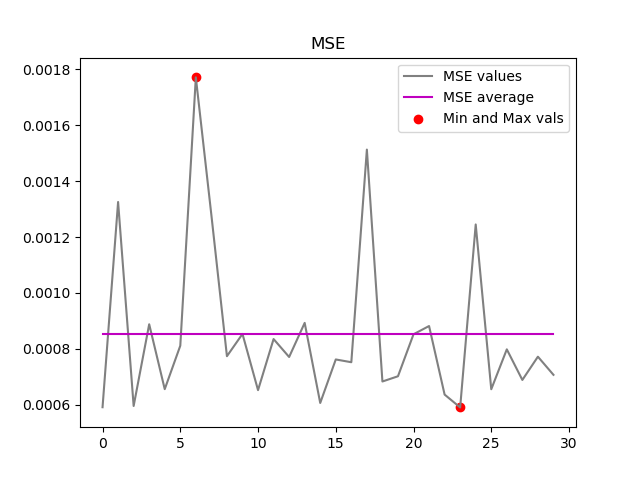

In [39]:
plot_mse(mse_list_100_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 80us/step
MSE: 0.032856455147266386


<IPython.core.display.Javascript object>


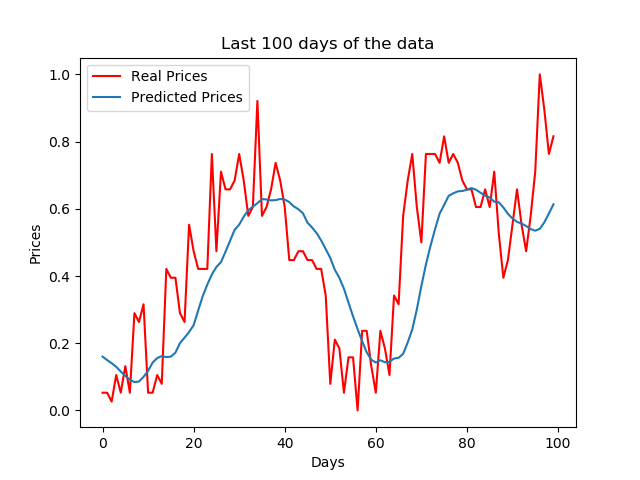

In [40]:
model1_100 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 39us/step
MSE: 0.0027662836806848644


<IPython.core.display.Javascript object>


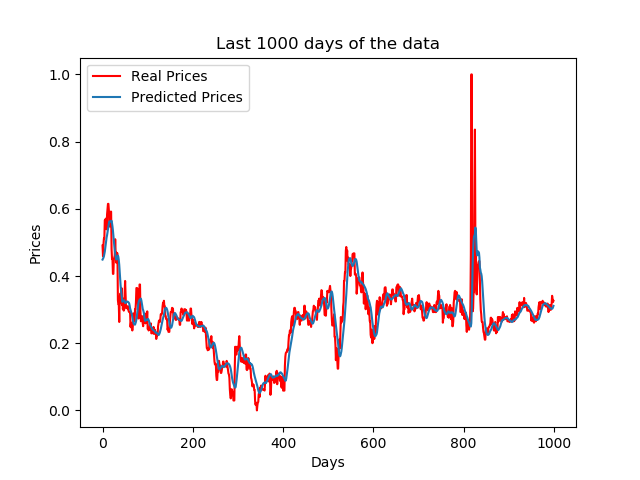

In [41]:
model1_1000 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 36us/step
MSE: 0.0015510403451044113


<IPython.core.display.Javascript object>


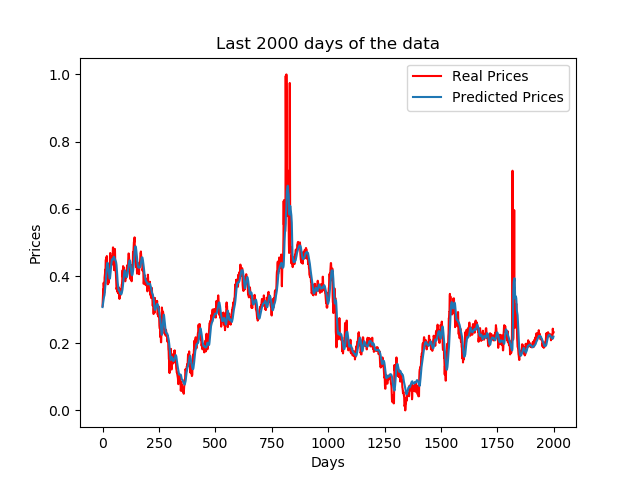

In [42]:
model1_2000 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 2

## Training model 2:

**(100 input samples extracted, 50% training and 50% testing)**

In [43]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_100_50[epoch].shape)
    print(y_train_all_100_50[epoch].shape)
    
    # fit the model to the current data
    model_100_50.fit(X_train_all_100_50[epoch],
                     y_train_all_100_50[epoch],
                     validation_data=(X_val_all_100_50[epoch], y_val_all_100_50[epoch]),
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(2669, 25, 1)
(2669, 1)
Train on 2669 samples, validate on 1335 samples
Epoch 1/20
2669/2669 [==============================] - 1s 371us/step - loss: 0.0320 - val_loss: 0.0307
Epoch 2/20
2669/2669 [==============================] - 0s 24us/step - loss: 0.0299 - val_loss: 0.0285
Epoch 3/20
2669/2669 [==============================] - 0s 19us/step - loss: 0.0277 - val_loss: 0.0264
Epoch 4/20
2669/2669 [==============================] - 0s 26us/step - loss: 0.0257 - val_loss: 0.0244
Epoch 5/20
2669/2669 [==============================] - 0s 26us/step - loss: 0.0237 - val_loss: 0.0224
Epoch 6/20
2669/2669 [==============================] - 0s 21us/step - loss: 0.0218 - val_loss: 0.0206
Epoch 7/20
2669/2669 [==============================] - 0s 22us/step - loss: 0.0200 - val_loss: 0.0189
Epoch 8/20
2669/2669 [==============================] - 0s 23us/step - loss: 0.0183 - val_loss: 0.0172
Epoch 9/20
2669/2669 [==============================] - 0s 20us/step - loss: 0.0167 - val_loss:

2651/2651 [==============================] - 0s 45us/step - loss: 9.5965e-04 - val_loss: 6.3112e-04
Epoch 17/20
2651/2651 [==============================] - 0s 49us/step - loss: 9.5756e-04 - val_loss: 6.2911e-04
Epoch 18/20
2651/2651 [==============================] - 0s 45us/step - loss: 9.5482e-04 - val_loss: 6.2726e-04
Epoch 19/20
2651/2651 [==============================] - 0s 47us/step - loss: 9.5268e-04 - val_loss: 6.2549e-04
Epoch 20/20
2651/2651 [==============================] - 0s 50us/step - loss: 9.5048e-04 - val_loss: 6.2370e-04
epoch=4
(2664, 35, 1)
(2664, 1)
Train on 2664 samples, validate on 1333 samples
Epoch 1/20
2664/2664 [==============================] - 0s 27us/step - loss: 7.3928e-04 - val_loss: 5.7663e-04
Epoch 2/20
2664/2664 [==============================] - 0s 25us/step - loss: 7.3559e-04 - val_loss: 5.7195e-04
Epoch 3/20
2664/2664 [==============================] - 0s 27us/step - loss: 7.3180e-04 - val_loss: 5.6797e-04
Epoch 4/20
2664/2664 [=================

2654/2654 [==============================] - 0s 42us/step - loss: 8.2691e-04 - val_loss: 5.6770e-04
Epoch 19/20
2654/2654 [==============================] - 0s 40us/step - loss: 8.2628e-04 - val_loss: 5.6721e-04
Epoch 20/20
2654/2654 [==============================] - 0s 52us/step - loss: 8.2557e-04 - val_loss: 5.6647e-04
epoch=11
(2652, 60, 1)
(2652, 1)
Train on 2652 samples, validate on 1326 samples
Epoch 1/20
2652/2652 [==============================] - 0s 44us/step - loss: 6.2101e-04 - val_loss: 5.5311e-04
Epoch 2/20
2652/2652 [==============================] - 0s 49us/step - loss: 6.1936e-04 - val_loss: 5.5280e-04
Epoch 3/20
2652/2652 [==============================] - 0s 46us/step - loss: 6.1784e-04 - val_loss: 5.5326e-04
Epoch 4/20
2652/2652 [==============================] - 0s 44us/step - loss: 6.1630e-04 - val_loss: 5.5381e-04
Epoch 5/20
2652/2652 [==============================] - 0s 46us/step - loss: 6.1527e-04 - val_loss: 5.5410e-04
Epoch 6/20
2652/2652 [==================

2663/2663 [==============================] - 0s 36us/step - loss: 6.6012e-04 - val_loss: 5.0434e-04
epoch=18
(2666, 32, 1)
(2666, 1)
Train on 2666 samples, validate on 1333 samples
Epoch 1/20
2666/2666 [==============================] - 0s 31us/step - loss: 4.7827e-04 - val_loss: 8.2651e-04
Epoch 2/20
2666/2666 [==============================] - 0s 27us/step - loss: 4.7791e-04 - val_loss: 8.2610e-04
Epoch 3/20
2666/2666 [==============================] - 0s 25us/step - loss: 4.7767e-04 - val_loss: 8.2558e-04
Epoch 4/20
2666/2666 [==============================] - 0s 27us/step - loss: 4.7716e-04 - val_loss: 8.2519e-04
Epoch 5/20
2666/2666 [==============================] - 0s 26us/step - loss: 4.7682e-04 - val_loss: 8.2481e-04
Epoch 6/20
2666/2666 [==============================] - 0s 31us/step - loss: 4.7648e-04 - val_loss: 8.2434e-04
Epoch 7/20
2666/2666 [==============================] - 0s 28us/step - loss: 4.7610e-04 - val_loss: 8.2385e-04
Epoch 8/20
2666/2666 [====================

2635/2635 [==============================] - 0s 80us/step - loss: 6.8319e-04 - val_loss: 4.6946e-04
Epoch 2/20
2635/2635 [==============================] - 0s 76us/step - loss: 6.8250e-04 - val_loss: 4.6939e-04
Epoch 3/20
2635/2635 [==============================] - 0s 82us/step - loss: 6.8174e-04 - val_loss: 4.6937e-04
Epoch 4/20
2635/2635 [==============================] - 0s 80us/step - loss: 6.8142e-04 - val_loss: 4.6948e-04
Epoch 5/20
2635/2635 [==============================] - 0s 76us/step - loss: 6.8087e-04 - val_loss: 4.6909e-04
Epoch 6/20
2635/2635 [==============================] - 0s 73us/step - loss: 6.8032e-04 - val_loss: 4.6820e-04
Epoch 7/20
2635/2635 [==============================] - 0s 79us/step - loss: 6.7983e-04 - val_loss: 4.6743e-04
Epoch 8/20
2635/2635 [==============================] - 0s 74us/step - loss: 6.7960e-04 - val_loss: 4.6670e-04
Epoch 9/20
2635/2635 [==============================] - 0s 77us/step - loss: 6.7895e-04 - val_loss: 4.6624e-04
Epoch 10/20


## Testing model 2:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_100_50, X_test_all_100_50, y_test_all_100_50)

In [45]:
mse_list_100_50 = mse_list(model_100_50, X_test_all_100_50, y_test_all_100_50, lengths)

Max mse: 0.0007974940026113554 (related window: 25)
Min mse: 0.00032514636775510784 (related window: 93)
Average mse: 0.000529765605490707


<IPython.core.display.Javascript object>


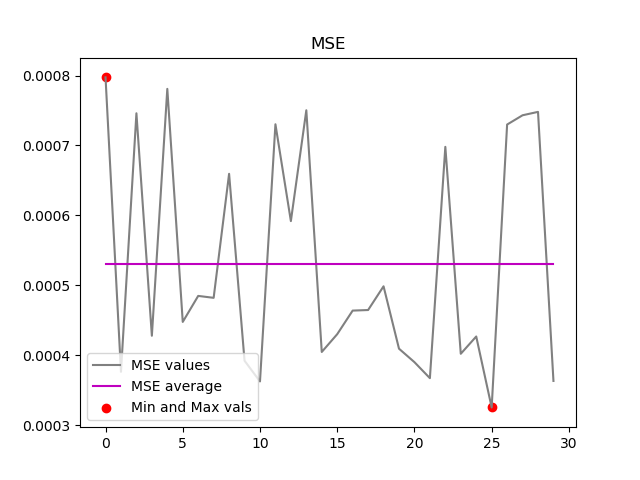

In [46]:
plot_mse(mse_list_100_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 100us/step
MSE: 0.024190534949302674


<IPython.core.display.Javascript object>


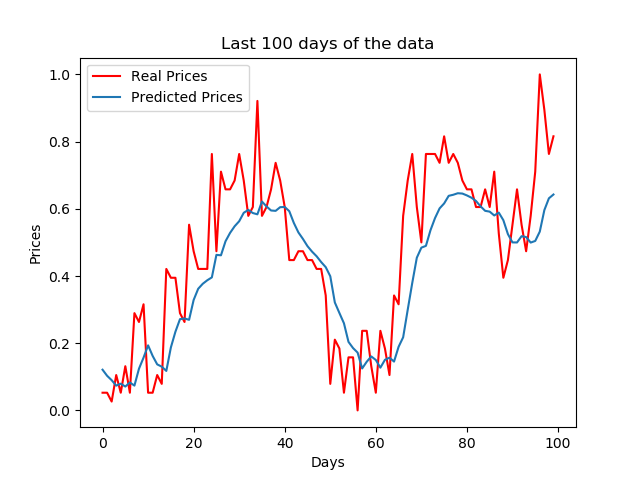

In [47]:
model2_100 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 37us/step
MSE: 0.002069626003969461


<IPython.core.display.Javascript object>


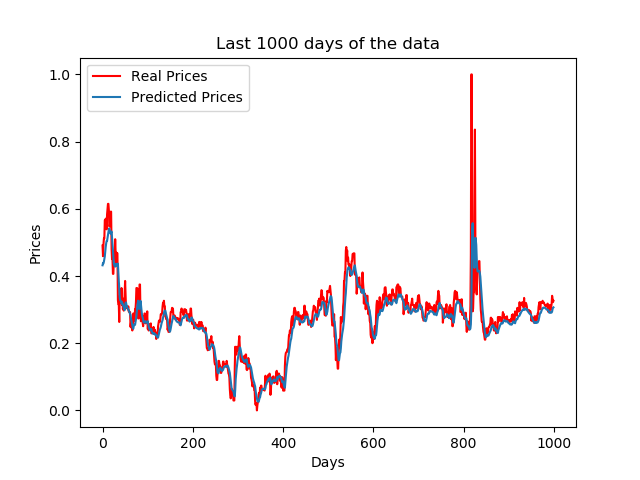

In [48]:
model2_1000 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 37us/step
MSE: 0.0013177413810044527


<IPython.core.display.Javascript object>


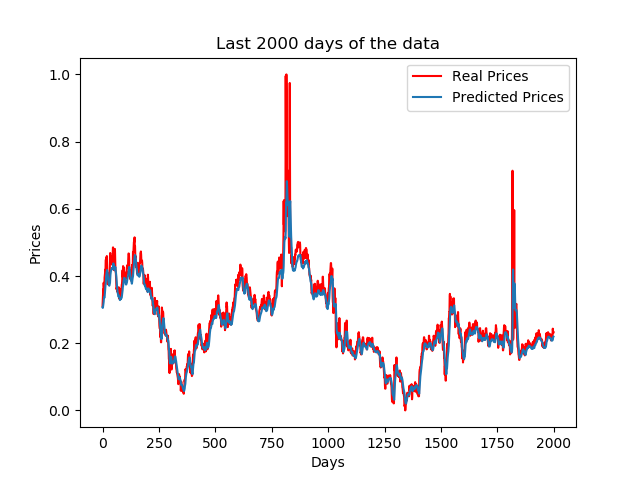

In [49]:
model2_2000 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# Model 3

## Training model 3:

**(1000 input samples extracted, 70% training and 30% testing)**

In [50]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_1000_70[epoch].shape)
    print(y_train_all_1000_70[epoch].shape)
    
    # fit the model to the current data
    model_1000_70.fit(X_train_all_1000_70[epoch],
                      y_train_all_1000_70[epoch],
                      validation_data=(X_val_all_1000_70[epoch], y_val_all_1000_70[epoch]),
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE)
    
    
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(3107, 25, 1)
(3107, 1)
Train on 3107 samples, validate on 666 samples
Epoch 1/20
3107/3107 [==============================] - 1s 420us/step - loss: 0.0997 - val_loss: 0.0947
Epoch 2/20
3107/3107 [==============================] - 0s 22us/step - loss: 0.0934 - val_loss: 0.0886
Epoch 3/20
3107/3107 [==============================] - 0s 22us/step - loss: 0.0874 - val_loss: 0.0828
Epoch 4/20
3107/3107 [==============================] - 0s 22us/step - loss: 0.0816 - val_loss: 0.0772
Epoch 5/20
3107/3107 [==============================] - 0s 28us/step - loss: 0.0762 - val_loss: 0.0720
Epoch 6/20
3107/3107 [==============================] - 0s 20us/step - loss: 0.0710 - val_loss: 0.0671
Epoch 7/20
3107/3107 [==============================] - 0s 26us/step - loss: 0.0661 - val_loss: 0.0624
Epoch 8/20
3107/3107 [==============================] - 0s 19us/step - loss: 0.0615 - val_loss: 0.0581
Epoch 9/20
3107/3107 [==============================] - 0s 21us/step - loss: 0.0572 - val_loss: 

3082/3082 [==============================] - 0s 53us/step - loss: 0.0029 - val_loss: 0.0022
Epoch 18/20
3082/3082 [==============================] - 0s 54us/step - loss: 0.0028 - val_loss: 0.0021
Epoch 19/20
3082/3082 [==============================] - 0s 48us/step - loss: 0.0027 - val_loss: 0.0020
Epoch 20/20
3082/3082 [==============================] - 0s 48us/step - loss: 0.0026 - val_loss: 0.0019
epoch=4
(3100, 35, 1)
(3100, 1)
Train on 3100 samples, validate on 665 samples
Epoch 1/20
3100/3100 [==============================] - 0s 31us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 2/20
3100/3100 [==============================] - 0s 32us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/20
3100/3100 [==============================] - 0s 31us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 4/20
3100/3100 [==============================] - 0s 27us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/20
3100/3100 [==============================] - 0s 39us/step - loss: 0.0018 - val_loss: 0.0019
Ep

Epoch 6/20
3082/3082 [==============================] - 0s 48us/step - loss: 9.6570e-04 - val_loss: 7.9087e-04
Epoch 7/20
3082/3082 [==============================] - 0s 45us/step - loss: 9.6125e-04 - val_loss: 8.0028e-04
Epoch 8/20
3082/3082 [==============================] - 0s 46us/step - loss: 9.5800e-04 - val_loss: 8.1205e-04
Epoch 9/20
3082/3082 [==============================] - 0s 48us/step - loss: 9.5674e-04 - val_loss: 8.1728e-04
Epoch 10/20
3082/3082 [==============================] - 0s 48us/step - loss: 9.5467e-04 - val_loss: 8.1172e-04
Epoch 11/20
3082/3082 [==============================] - 0s 50us/step - loss: 9.5259e-04 - val_loss: 8.0601e-04
Epoch 12/20
3082/3082 [==============================] - 0s 58us/step - loss: 9.5166e-04 - val_loss: 7.9918e-04
Epoch 13/20
3082/3082 [==============================] - 0s 51us/step - loss: 9.5196e-04 - val_loss: 7.9040e-04
Epoch 14/20
3082/3082 [==============================] - 0s 53us/step - loss: 9.5287e-04 - val_loss: 7.8506e

3102/3102 [==============================] - 0s 27us/step - loss: 8.9644e-04 - val_loss: 6.4055e-04
Epoch 10/20
3102/3102 [==============================] - 0s 26us/step - loss: 8.9565e-04 - val_loss: 6.3986e-04
Epoch 11/20
3102/3102 [==============================] - 0s 25us/step - loss: 8.9472e-04 - val_loss: 6.3925e-04
Epoch 12/20
3102/3102 [==============================] - 0s 24us/step - loss: 8.9371e-04 - val_loss: 6.3787e-04
Epoch 13/20
3102/3102 [==============================] - 0s 26us/step - loss: 8.9318e-04 - val_loss: 6.3695e-04
Epoch 14/20
3102/3102 [==============================] - 0s 25us/step - loss: 8.9209e-04 - val_loss: 6.3722e-04
Epoch 15/20
3102/3102 [==============================] - 0s 24us/step - loss: 8.9131e-04 - val_loss: 6.3610e-04
Epoch 16/20
3102/3102 [==============================] - 0s 30us/step - loss: 8.9031e-04 - val_loss: 6.3813e-04
Epoch 17/20
3102/3102 [==============================] - 0s 27us/step - loss: 8.8861e-04 - val_loss: 6.3978e-04
Epoc

3059/3059 [==============================] - 0s 63us/step - loss: 7.7389e-04 - val_loss: 5.7859e-04
Epoch 11/20
3059/3059 [==============================] - 0s 64us/step - loss: 7.7339e-04 - val_loss: 5.7819e-04
Epoch 12/20
3059/3059 [==============================] - 0s 65us/step - loss: 7.7276e-04 - val_loss: 5.7785e-04
Epoch 13/20
3059/3059 [==============================] - 0s 62us/step - loss: 7.7225e-04 - val_loss: 5.7741e-04
Epoch 14/20
3059/3059 [==============================] - 0s 57us/step - loss: 7.7167e-04 - val_loss: 5.7700e-04
Epoch 15/20
3059/3059 [==============================] - 0s 69us/step - loss: 7.7117e-04 - val_loss: 5.7661e-04
Epoch 16/20
3059/3059 [==============================] - 0s 67us/step - loss: 7.7066e-04 - val_loss: 5.7633e-04
Epoch 17/20
3059/3059 [==============================] - 0s 61us/step - loss: 7.7014e-04 - val_loss: 5.7588e-04
Epoch 18/20
3059/3059 [==============================] - 0s 62us/step - loss: 7.6951e-04 - val_loss: 5.7550e-04
Epoc

3084/3084 [==============================] - 0s 44us/step - loss: 6.1870e-04 - val_loss: 0.0011
Epoch 2/20
3084/3084 [==============================] - 0s 43us/step - loss: 6.1813e-04 - val_loss: 0.0011
Epoch 3/20
3084/3084 [==============================] - 0s 46us/step - loss: 6.1842e-04 - val_loss: 0.0011
Epoch 4/20
3084/3084 [==============================] - 0s 49us/step - loss: 6.2117e-04 - val_loss: 0.0011
Epoch 5/20
3084/3084 [==============================] - 0s 43us/step - loss: 6.2215e-04 - val_loss: 0.0011
Epoch 6/20
3084/3084 [==============================] - 0s 46us/step - loss: 6.1836e-04 - val_loss: 0.0011
Epoch 7/20
3084/3084 [==============================] - 0s 45us/step - loss: 6.1510e-04 - val_loss: 0.0011
Epoch 8/20
3084/3084 [==============================] - 0s 50us/step - loss: 6.1443e-04 - val_loss: 0.0011
Epoch 9/20
3084/3084 [==============================] - 0s 48us/step - loss: 6.1373e-04 - val_loss: 0.0011
Epoch 10/20
3084/3084 [=========================

## Testing model 3:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_1000_70, X_test_all_1000_70, y_test_all_1000_70)

In [52]:
mse_list_1000_70 = mse_list(model_1000_70, X_test_all_1000_70, y_test_all_1000_70, lengths)

Max mse: 0.001506529815063015 (related window: 35)
Min mse: 0.00044548481875323655 (related window: 34)
Average mse: 0.0007393231137103124


<IPython.core.display.Javascript object>


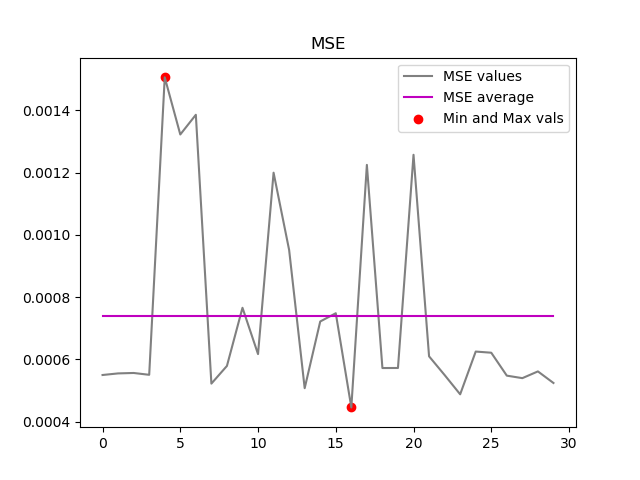

In [53]:
plot_mse(mse_list_1000_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 80us/step
MSE: 0.02608091205358505


<IPython.core.display.Javascript object>


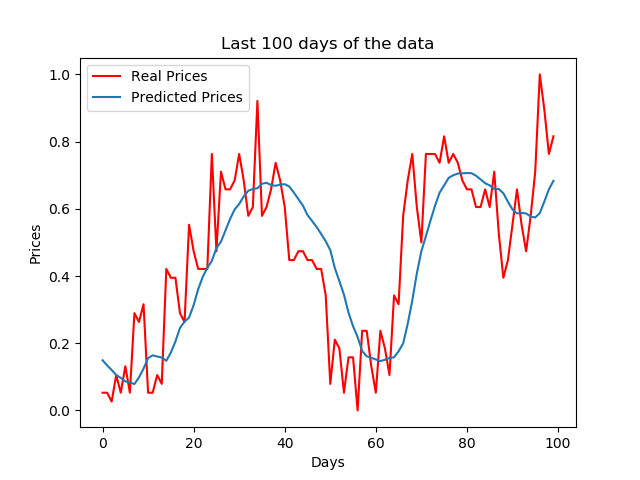

In [54]:
model3_100 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 42us/step
MSE: 0.0028840985866263507


<IPython.core.display.Javascript object>


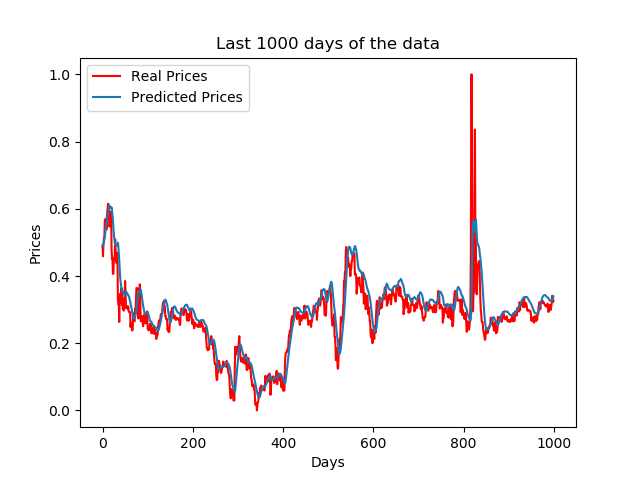

In [55]:
model3_1000 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 37us/step
MSE: 0.0017371954643167556


<IPython.core.display.Javascript object>


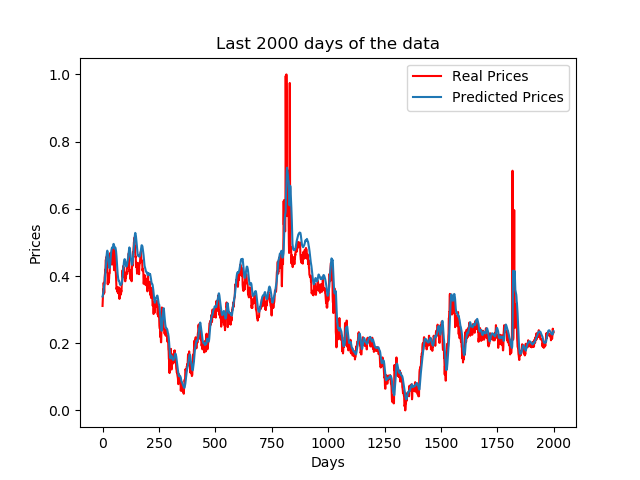

In [56]:
model3_2000 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 4

## Training model 4:

**(1000 input samples extracted, 50% training and 50% testing)**

In [57]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_1000_50[epoch].shape)
    print(y_train_all_1000_50[epoch].shape)
    
    # fit the model to the current data
    model_1000_50.fit(X_train_all_1000_50[epoch],
                      y_train_all_1000_50[epoch],
                      validation_data=(X_val_all_1000_50[epoch], y_val_all_1000_50[epoch]),
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(2219, 25, 1)
(2219, 1)
Train on 2219 samples, validate on 1110 samples
Epoch 1/20
2219/2219 [==============================] - 1s 493us/step - loss: 0.1021 - val_loss: 0.0995
Epoch 2/20
2219/2219 [==============================] - 0s 26us/step - loss: 0.0968 - val_loss: 0.0942
Epoch 3/20
2219/2219 [==============================] - 0s 26us/step - loss: 0.0917 - val_loss: 0.0892
Epoch 4/20
2219/2219 [==============================] - 0s 25us/step - loss: 0.0868 - val_loss: 0.0843
Epoch 5/20
2219/2219 [==============================] - 0s 26us/step - loss: 0.0820 - val_loss: 0.0796
Epoch 6/20
2219/2219 [==============================] - 0s 25us/step - loss: 0.0774 - val_loss: 0.0750
Epoch 7/20
2219/2219 [==============================] - 0s 28us/step - loss: 0.0729 - val_loss: 0.0707
Epoch 8/20
2219/2219 [==============================] - 0s 28us/step - loss: 0.0686 - val_loss: 0.0664
Epoch 9/20
2219/2219 [==============================] - 0s 23us/step - loss: 0.0645 - val_loss:

2201/2201 [==============================] - 0s 53us/step - loss: 0.0040 - val_loss: 0.0032
Epoch 18/20
2201/2201 [==============================] - 0s 51us/step - loss: 0.0038 - val_loss: 0.0030
Epoch 19/20
2201/2201 [==============================] - 0s 56us/step - loss: 0.0036 - val_loss: 0.0028
Epoch 20/20
2201/2201 [==============================] - 0s 52us/step - loss: 0.0035 - val_loss: 0.0027
epoch=4
(2214, 35, 1)
(2214, 1)
Train on 2214 samples, validate on 1108 samples
Epoch 1/20
2214/2214 [==============================] - 0s 37us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 2/20
2214/2214 [==============================] - 0s 34us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 3/20
2214/2214 [==============================] - 0s 32us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/20
2214/2214 [==============================] - 0s 35us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/20
2214/2214 [==============================] - 0s 33us/step - loss: 0.0026 - val_loss: 0.0025
E

2202/2202 [==============================] - 0s 48us/step - loss: 0.0013 - val_loss: 9.1019e-04
Epoch 9/20
2202/2202 [==============================] - 0s 52us/step - loss: 0.0013 - val_loss: 9.0846e-04
Epoch 10/20
2202/2202 [==============================] - 0s 54us/step - loss: 0.0013 - val_loss: 9.0679e-04
Epoch 11/20
2202/2202 [==============================] - 0s 50us/step - loss: 0.0013 - val_loss: 9.0511e-04
Epoch 12/20
2202/2202 [==============================] - 0s 51us/step - loss: 0.0013 - val_loss: 9.0336e-04
Epoch 13/20
2202/2202 [==============================] - 0s 50us/step - loss: 0.0013 - val_loss: 9.0170e-04
Epoch 14/20
2202/2202 [==============================] - 0s 59us/step - loss: 0.0013 - val_loss: 9.0029e-04
Epoch 15/20
2202/2202 [==============================] - 0s 50us/step - loss: 0.0013 - val_loss: 8.9836e-04
Epoch 16/20
2202/2202 [==============================] - 0s 56us/step - loss: 0.0013 - val_loss: 8.9643e-04
Epoch 17/20
2202/2202 [==================

2216/2216 [==============================] - 0s 32us/step - loss: 9.8847e-04 - val_loss: 7.8978e-04
Epoch 15/20
2216/2216 [==============================] - 0s 35us/step - loss: 9.8728e-04 - val_loss: 7.8941e-04
Epoch 16/20
2216/2216 [==============================] - 0s 35us/step - loss: 9.8637e-04 - val_loss: 7.8904e-04
Epoch 17/20
2216/2216 [==============================] - 0s 36us/step - loss: 9.8539e-04 - val_loss: 7.8849e-04
Epoch 18/20
2216/2216 [==============================] - 0s 54us/step - loss: 9.8453e-04 - val_loss: 7.8775e-04
Epoch 19/20
2216/2216 [==============================] - 0s 69us/step - loss: 9.8360e-04 - val_loss: 7.8677e-04
Epoch 20/20
2216/2216 [==============================] - 0s 39us/step - loss: 9.8249e-04 - val_loss: 7.8581e-04
epoch=19
(2186, 91, 1)
(2186, 1)
Train on 2186 samples, validate on 1094 samples
Epoch 1/20
2186/2186 [==============================] - 0s 92us/step - loss: 0.0010 - val_loss: 6.8804e-04
Epoch 2/20
2186/2186 [==================

Epoch 6/20
2205/2205 [==============================] - 0s 48us/step - loss: 9.6189e-04 - val_loss: 5.8006e-04
Epoch 7/20
2205/2205 [==============================] - 0s 45us/step - loss: 9.6229e-04 - val_loss: 5.7990e-04
Epoch 8/20
2205/2205 [==============================] - 0s 47us/step - loss: 9.6189e-04 - val_loss: 5.7891e-04
Epoch 9/20
2205/2205 [==============================] - 0s 46us/step - loss: 9.6007e-04 - val_loss: 5.7773e-04
Epoch 10/20
2205/2205 [==============================] - 0s 47us/step - loss: 9.5821e-04 - val_loss: 5.7700e-04
Epoch 11/20
2205/2205 [==============================] - 0s 43us/step - loss: 9.5640e-04 - val_loss: 5.7683e-04
Epoch 12/20
2205/2205 [==============================] - 0s 45us/step - loss: 9.5483e-04 - val_loss: 5.7639e-04
Epoch 13/20
2205/2205 [==============================] - 0s 52us/step - loss: 9.5391e-04 - val_loss: 5.7596e-04
Epoch 14/20
2205/2205 [==============================] - 0s 51us/step - loss: 9.5295e-04 - val_loss: 5.7496e

Epoch 8/20
2203/2203 [==============================] - 0s 48us/step - loss: 6.5220e-04 - val_loss: 0.0011
Epoch 9/20
2203/2203 [==============================] - 0s 50us/step - loss: 6.5201e-04 - val_loss: 0.0011
Epoch 10/20
2203/2203 [==============================] - 0s 46us/step - loss: 6.5106e-04 - val_loss: 0.0011
Epoch 11/20
2203/2203 [==============================] - 0s 48us/step - loss: 6.4964e-04 - val_loss: 0.0011
Epoch 12/20
2203/2203 [==============================] - 0s 53us/step - loss: 6.4812e-04 - val_loss: 0.0011
Epoch 13/20
2203/2203 [==============================] - 0s 48us/step - loss: 6.4697e-04 - val_loss: 0.0011
Epoch 14/20
2203/2203 [==============================] - 0s 53us/step - loss: 6.4612e-04 - val_loss: 0.0011
Epoch 15/20
2203/2203 [==============================] - 0s 48us/step - loss: 6.4553e-04 - val_loss: 0.0011
Epoch 16/20
2203/2203 [==============================] - 0s 48us/step - loss: 6.4562e-04 - val_loss: 0.0011
Epoch 17/20
2203/2203 [=======

## Testing model 4:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_1000_50, X_test_all_1000_50, y_test_all_1000_50)

In [59]:
mse_list_1000_50 = mse_list(model_1000_50, X_test_all_1000_50, y_test_all_1000_50, lengths)

Max mse: 0.0011080238454929281 (related window: 90)
Min mse: 0.0005348632886486902 (related window: 56)
Average mse: 0.0007743531205010375


<IPython.core.display.Javascript object>


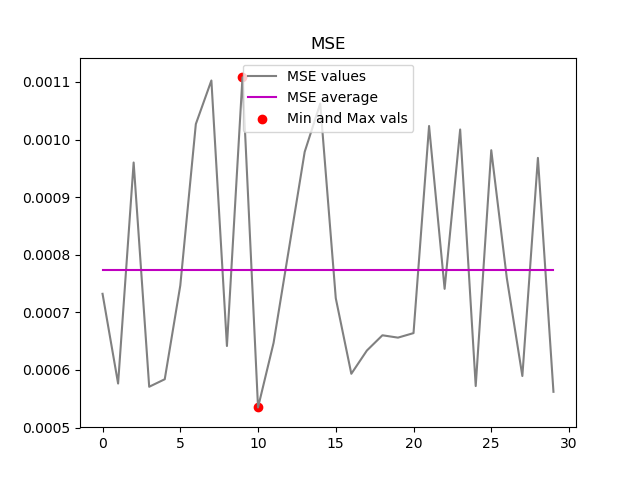

In [60]:
plot_mse(mse_list_1000_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 100us/step
MSE: 0.029102877974510194


<IPython.core.display.Javascript object>


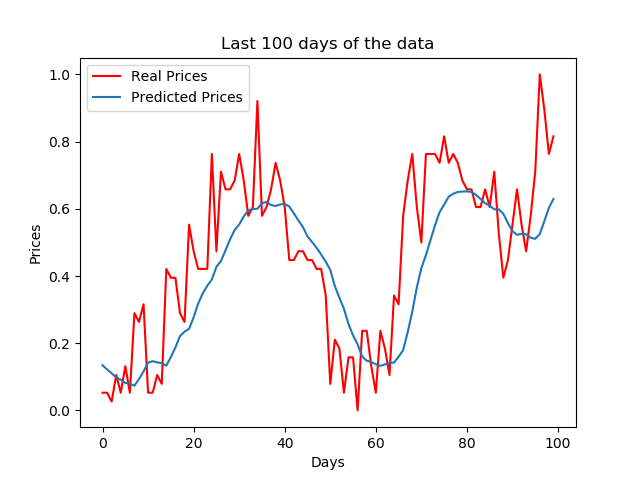

In [61]:
model4_100 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 47us/step
MSE: 0.002662262134253979


<IPython.core.display.Javascript object>


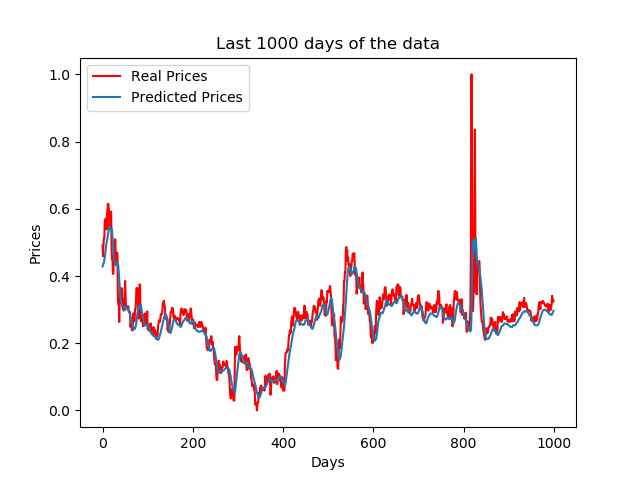

In [62]:
model4_1000 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 42us/step
MSE: 0.0016501111492980272


<IPython.core.display.Javascript object>


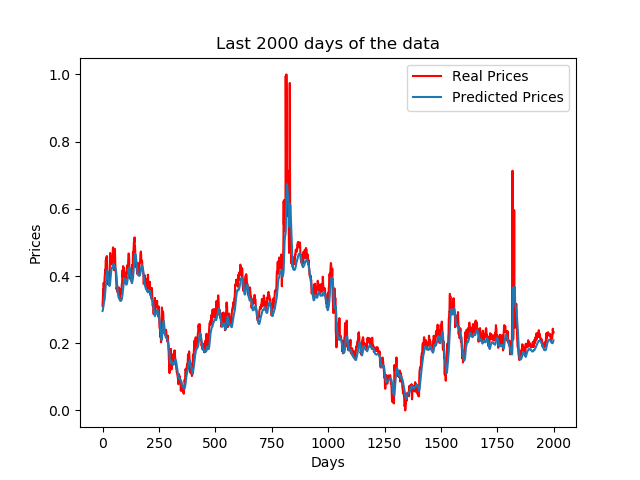

In [63]:
model4_2000 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 5

## Training model 5:

**(2000 input samples extracted, 70% training and 30% testing)**

In [64]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_2000_70[epoch].shape)
    print(y_train_all_2000_70[epoch].shape)
    
    # fit the model to the current data
    model_2000_70.fit(X_train_all_2000_70[epoch],
                      y_train_all_2000_70[epoch],
                      validation_data=(X_val_all_2000_70[epoch], y_val_all_2000_70[epoch]),
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(2407, 25, 1)
(2407, 1)
Train on 2407 samples, validate on 516 samples
Epoch 1/20
2407/2407 [==============================] - 1s 519us/step - loss: 0.1391 - val_loss: 0.1462
Epoch 2/20
2407/2407 [==============================] - 0s 22us/step - loss: 0.1295 - val_loss: 0.1363
Epoch 3/20
2407/2407 [==============================] - 0s 21us/step - loss: 0.1203 - val_loss: 0.1267
Epoch 4/20
2407/2407 [==============================] - 0s 22us/step - loss: 0.1115 - val_loss: 0.1177
Epoch 5/20
2407/2407 [==============================] - 0s 21us/step - loss: 0.1032 - val_loss: 0.1092
Epoch 6/20
2407/2407 [==============================] - 0s 22us/step - loss: 0.0954 - val_loss: 0.1012
Epoch 7/20
2407/2407 [==============================] - 0s 24us/step - loss: 0.0881 - val_loss: 0.0937
Epoch 8/20
2407/2407 [==============================] - 0s 21us/step - loss: 0.0811 - val_loss: 0.0866
Epoch 9/20
2407/2407 [==============================] - 0s 25us/step - loss: 0.0747 - val_loss: 

2382/2382 [==============================] - 0s 47us/step - loss: 0.0033 - val_loss: 0.0028
Epoch 18/20
2382/2382 [==============================] - 0s 45us/step - loss: 0.0032 - val_loss: 0.0027
Epoch 19/20
2382/2382 [==============================] - 0s 55us/step - loss: 0.0031 - val_loss: 0.0027
Epoch 20/20
2382/2382 [==============================] - 0s 54us/step - loss: 0.0030 - val_loss: 0.0026
epoch=4
(2400, 35, 1)
(2400, 1)
Train on 2400 samples, validate on 515 samples
Epoch 1/20
2400/2400 [==============================] - 0s 29us/step - loss: 0.0031 - val_loss: 0.0023
Epoch 2/20
2400/2400 [==============================] - 0s 31us/step - loss: 0.0030 - val_loss: 0.0022
Epoch 3/20
2400/2400 [==============================] - 0s 30us/step - loss: 0.0029 - val_loss: 0.0022
Epoch 4/20
2400/2400 [==============================] - 0s 30us/step - loss: 0.0028 - val_loss: 0.0021
Epoch 5/20
2400/2400 [==============================] - 0s 31us/step - loss: 0.0028 - val_loss: 0.0020
Ep

Epoch 13/20
2369/2369 [==============================] - 0s 62us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 14/20
2369/2369 [==============================] - 0s 61us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 15/20
2369/2369 [==============================] - 0s 65us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 16/20
2369/2369 [==============================] - 0s 63us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 17/20
2369/2369 [==============================] - 0s 64us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 18/20
2369/2369 [==============================] - 0s 64us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 19/20
2369/2369 [==============================] - 0s 58us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 20/20
2369/2369 [==============================] - 0s 61us/step - loss: 0.0019 - val_loss: 0.0014
epoch=8
(2404, 29, 1)
(2404, 1)
Train on 2404 samples, validate on 516 samples
Epoch 1/20
2404/2404 [==============================] - 0s 27us/step - loss: 0.0017 - val

2382/2382 [==============================] - 0s 45us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/20
2382/2382 [==============================] - 0s 49us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 11/20
2382/2382 [==============================] - 0s 52us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 12/20
2382/2382 [==============================] - 0s 48us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 13/20
2382/2382 [==============================] - 0s 52us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 14/20
2382/2382 [==============================] - 0s 50us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 15/20
2382/2382 [==============================] - 0s 47us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 16/20
2382/2382 [==============================] - 0s 49us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 17/20
2382/2382 [==============================] - 0s 48us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 18/20
2382/2382 [==============================] - 0s 49us/step - loss

2361/2361 [==============================] - 0s 76us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 2/20
2361/2361 [==============================] - 0s 82us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/20
2361/2361 [==============================] - 0s 79us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/20
2361/2361 [==============================] - 0s 82us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/20
2361/2361 [==============================] - 0s 91us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/20
2361/2361 [==============================] - 0s 76us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/20
2361/2361 [==============================] - 0s 71us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/20
2361/2361 [==============================] - 0s 76us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/20
2361/2361 [==============================] - 0s 73us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/20
2361/2361 [==============================] - 0s 73us/step - loss: 0.0011

Epoch 13/20
2396/2396 [==============================] - 0s 35us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 14/20
2396/2396 [==============================] - 0s 35us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 15/20
2396/2396 [==============================] - 0s 39us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 16/20
2396/2396 [==============================] - 0s 35us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 17/20
2396/2396 [==============================] - 0s 36us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 18/20
2396/2396 [==============================] - 0s 32us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 19/20
2396/2396 [==============================] - 0s 35us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 20/20
2396/2396 [==============================] - 0s 33us/step - loss: 0.0011 - val_loss: 0.0011
epoch=27
(2366, 84, 1)
(2366, 1)
Train on 2366 samples, validate on 507 samples
Epoch 1/20
2366/2366 [==============================] - 0s 75us/step - loss: 9.5702e-04 

## Testing model 5:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_2000_70, X_test_all_2000_70, y_test_all_2000_70)

In [67]:
mse_list_2000_70 = mse_list(model_2000_70, X_test_all_2000_70, y_test_all_2000_70, lengths)

Max mse: 0.002235932692770332 (related window: 10)
Min mse: 0.000729820704137212 (related window: 84)
Average mse: 0.0010729415112109629


<IPython.core.display.Javascript object>


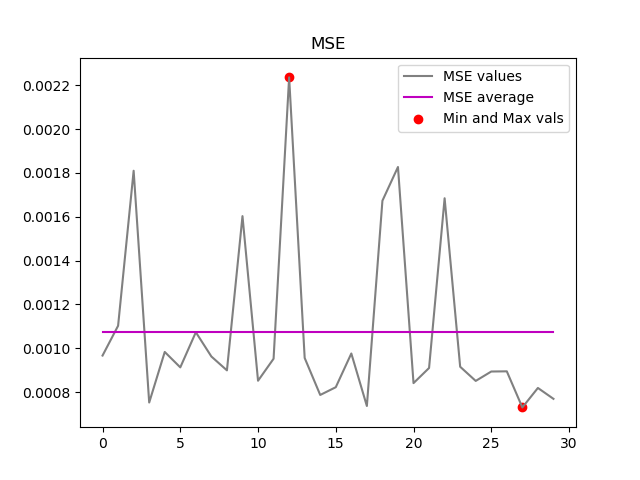

In [68]:
plot_mse(mse_list_2000_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 100us/step
MSE: 0.03757722377777099


<IPython.core.display.Javascript object>


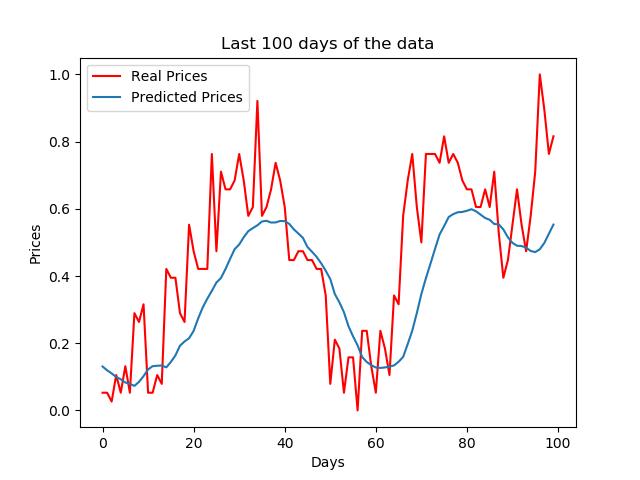

In [69]:
model5_100 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 57us/step
MSE: 0.003847349811345339


<IPython.core.display.Javascript object>


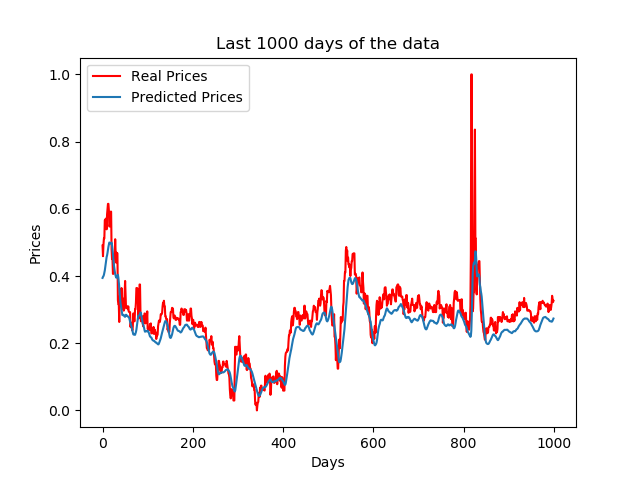

In [70]:
model5_1000 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 43us/step
MSE: 0.002822033260483295


<IPython.core.display.Javascript object>


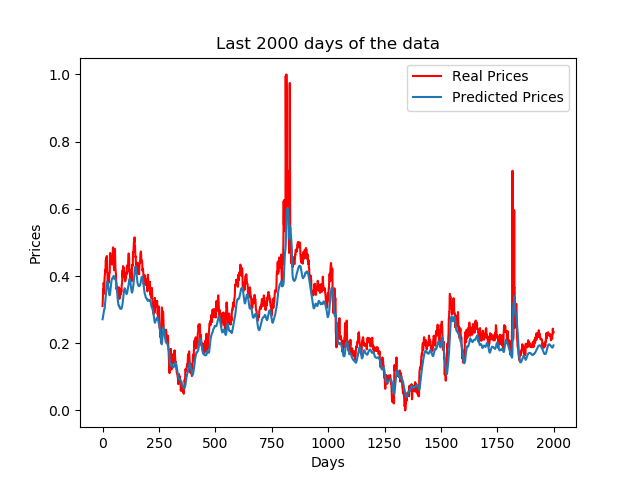

In [71]:
model5_2000 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 6

## Training model 6:

**(2000 input samples extracted, 50% training and 50% testing)**

In [72]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_2000_50[epoch].shape)
    print(y_train_all_2000_50[epoch].shape)
    
    # fit the model to the current data
    model_2000_50.fit(X_train_all_2000_50[epoch],
                      y_train_all_2000_50[epoch],
                      validation_data=(X_val_all_2000_50[epoch], y_val_all_2000_50[epoch]),
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(1719, 25, 1)
(1719, 1)
Train on 1719 samples, validate on 860 samples
Epoch 1/20
1719/1719 [==============================] - 1s 835us/step - loss: 0.0965 - val_loss: 0.1019
Epoch 2/20
1719/1719 [==============================] - 0s 27us/step - loss: 0.0923 - val_loss: 0.0976
Epoch 3/20
1719/1719 [==============================] - 0s 24us/step - loss: 0.0883 - val_loss: 0.0934
Epoch 4/20
1719/1719 [==============================] - 0s 27us/step - loss: 0.0844 - val_loss: 0.0894
Epoch 5/20
1719/1719 [==============================] - 0s 27us/step - loss: 0.0807 - val_loss: 0.0855
Epoch 6/20
1719/1719 [==============================] - 0s 25us/step - loss: 0.0771 - val_loss: 0.0818
Epoch 7/20
1719/1719 [==============================] - 0s 27us/step - loss: 0.0735 - val_loss: 0.0781
Epoch 8/20
1719/1719 [==============================] - 0s 26us/step - loss: 0.0701 - val_loss: 0.0746
Epoch 9/20
1719/1719 [==============================] - 0s 24us/step - loss: 0.0669 - val_loss: 

1692/1692 [==============================] - 0s 74us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 13/20
1692/1692 [==============================] - 0s 71us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 14/20
1692/1692 [==============================] - 0s 80us/step - loss: 0.0038 - val_loss: 0.0036
Epoch 15/20
1692/1692 [==============================] - 0s 67us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 16/20
1692/1692 [==============================] - 0s 78us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 17/20
1692/1692 [==============================] - 0s 80us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 18/20
1692/1692 [==============================] - 0s 75us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 19/20
1692/1692 [==============================] - 0s 74us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 20/20
1692/1692 [==============================] - 0s 72us/step - loss: 0.0023 - val_loss: 0.0021
epoch=8
(1717, 29, 1)
(1717, 1)
Train on 1717 samples, validate on 859 sampl

1687/1687 [==============================] - 0s 83us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/20
1687/1687 [==============================] - 0s 93us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 6/20
1687/1687 [==============================] - 0s 109us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7/20
1687/1687 [==============================] - 0s 100us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/20
1687/1687 [==============================] - 0s 89us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/20
1687/1687 [==============================] - 0s 100us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/20
1687/1687 [==============================] - 0s 100us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 11/20
1687/1687 [==============================] - 0s 90us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 12/20
1687/1687 [==============================] - 0s 95us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 13/20
1687/1687 [==============================] - 0s 89us/step - loss:

epoch=19
(1686, 91, 1)
(1686, 1)
Train on 1686 samples, validate on 844 samples
Epoch 1/20
1686/1686 [==============================] - 0s 81us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2/20
1686/1686 [==============================] - 0s 77us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/20
1686/1686 [==============================] - 0s 77us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/20
1686/1686 [==============================] - 0s 75us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/20
1686/1686 [==============================] - 0s 75us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/20
1686/1686 [==============================] - 0s 95us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/20
1686/1686 [==============================] - 0s 93us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/20
1686/1686 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/20
1686/1686 [==============================] - 0s 89us/step - loss: 0.0013 - val_loss: 

1705/1705 [==============================] - 0s 54us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 18/20
1705/1705 [==============================] - 0s 50us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 19/20
1705/1705 [==============================] - 0s 51us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 20/20
1705/1705 [==============================] - 0s 50us/step - loss: 0.0013 - val_loss: 0.0012
epoch=23
(1688, 87, 1)
(1688, 1)
Train on 1688 samples, validate on 845 samples
Epoch 1/20
1688/1688 [==============================] - 0s 88us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 2/20
1688/1688 [==============================] - 0s 82us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/20
1688/1688 [==============================] - 0s 85us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/20
1688/1688 [==============================] - 0s 83us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/20
1688/1688 [==============================] - 0s 84us/step - loss: 0.0016 - val_loss: 0.0013
E

Epoch 13/20
1712/1712 [==============================] - 0s 36us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 14/20
1712/1712 [==============================] - 0s 36us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 15/20
1712/1712 [==============================] - 0s 39us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 16/20
1712/1712 [==============================] - 0s 41us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 17/20
1712/1712 [==============================] - 0s 37us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 18/20
1712/1712 [==============================] - 0s 38us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 19/20
1712/1712 [==============================] - 0s 38us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 20/20
1712/1712 [==============================] - 0s 44us/step - loss: 0.0012 - val_loss: 0.0018
epoch=27
(1690, 84, 1)
(1690, 1)
Train on 1690 samples, validate on 845 samples
Epoch 1/20
1690/1690 [==============================] - 0s 84us/step - loss: 0.0012 - va

## Testing model 6:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_2000_50, X_test_all_2000_50, y_test_all_2000_50)

In [76]:
mse_list_2000_50 = mse_list(model_2000_50, X_test_all_2000_50, y_test_all_2000_50, lengths)

Max mse: 0.004457864001704118 (related window: 10)
Min mse: 0.0009809659117139703 (related window: 25)
Average mse: 0.001476047034173533


<IPython.core.display.Javascript object>


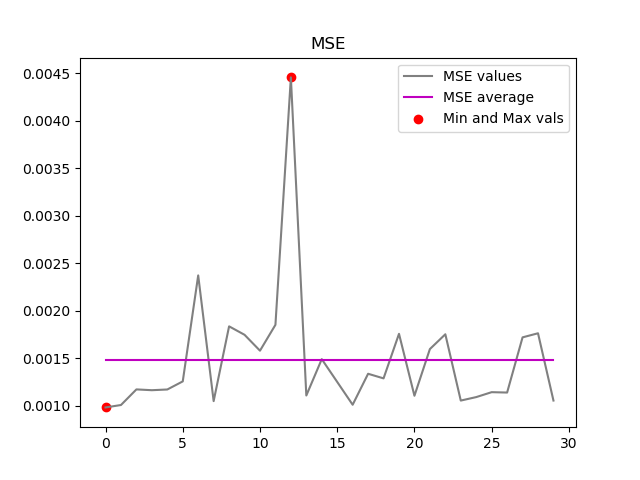

In [77]:
plot_mse(mse_list_2000_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 80us/step
MSE: 0.05219513952732086


<IPython.core.display.Javascript object>


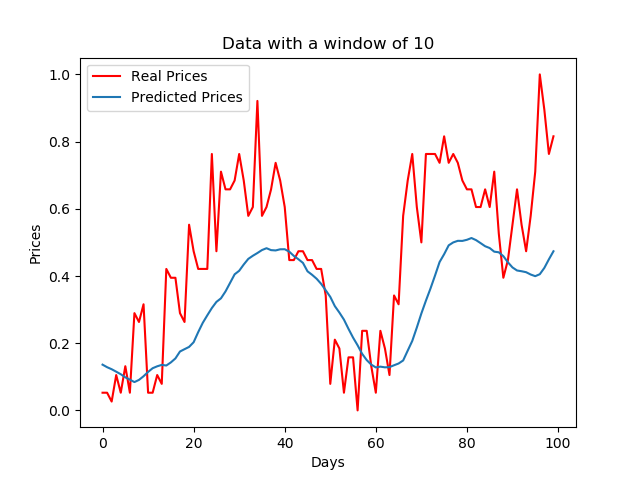

In [78]:
model6_100 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_100, y_test_sample_100)

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 44us/step
MSE: 0.006769049266353249


<IPython.core.display.Javascript object>


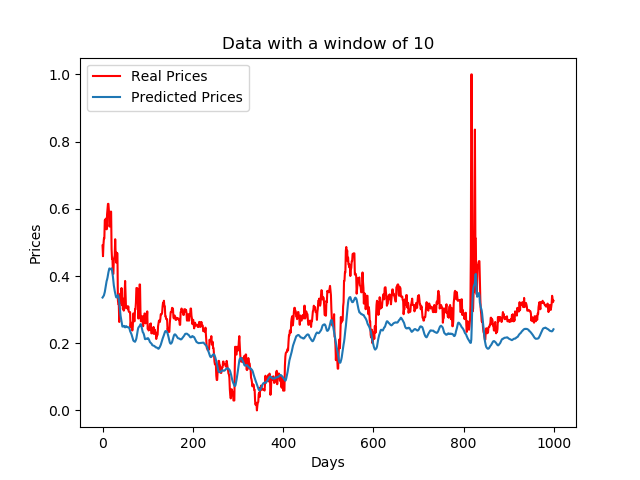

In [79]:
model6_1000 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_1000, y_test_sample_1000)

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 40us/step
MSE: 0.005950594155117869


<IPython.core.display.Javascript object>


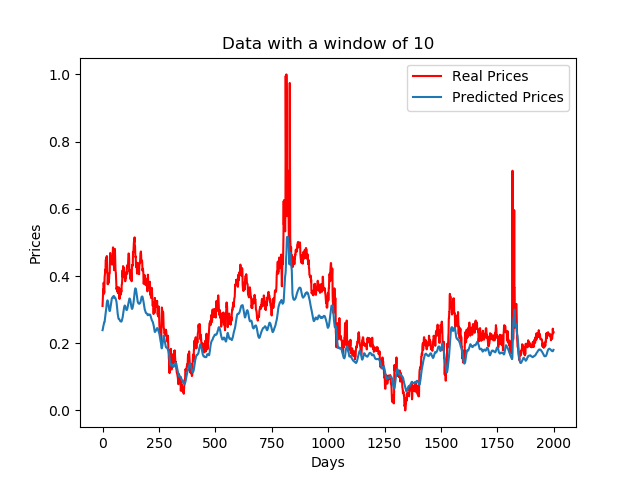

In [80]:
model6_2000 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_2000, y_test_sample_2000)

# Comparing Models

## Visually:

Prepare the lists that are needed as parameters for the functions that will be used.

In [81]:
all_test_mse_lists = [mse_list_100_70, # list of MSE values for the Model 1 on Testing data
                     mse_list_100_50, # list of MSE values for the Model 2 on Testing data
                     mse_list_1000_70, # list of MSE values for the Model 3 on Testing data
                     mse_list_1000_50, # list of MSE values for the Model 4 on Testing data
                     mse_list_2000_70, # list of MSE values for the Model 5 on Testing data
                     mse_list_2000_70 # list of MSE values for the Model 6 on Testing data
                    ]
# MSE for each model on the 100 saved unseen input sample
all_100_mse_list = [model1_100, model2_100, model3_100, model4_100, model5_100, model6_100]
# MSE for each model on the 1000 saved unseen input sample
all_1000_mse_list = [model1_1000, model2_1000, model3_1000, model4_1000, model5_1000, model6_1000]
# MSE for each model on the 2000 saved unseen input sample
all_2000_mse_list = [model1_2000, model2_2000, model3_2000, model4_2000, model5_2000, model6_2000]

In [82]:
x_ticks_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

## Plot MSE for models on testing data

Concretely, three barplots will be plotted showing the minimum, maximum and average MSE values, respectively, on the testing data.

<IPython.core.display.Javascript object>


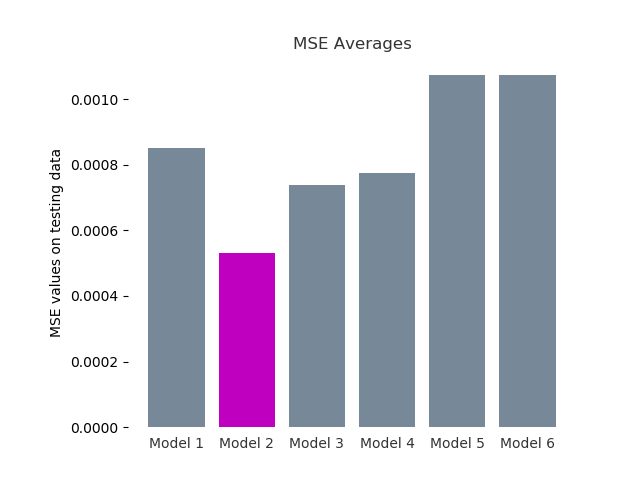

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<IPython.core.display.Javascript object>


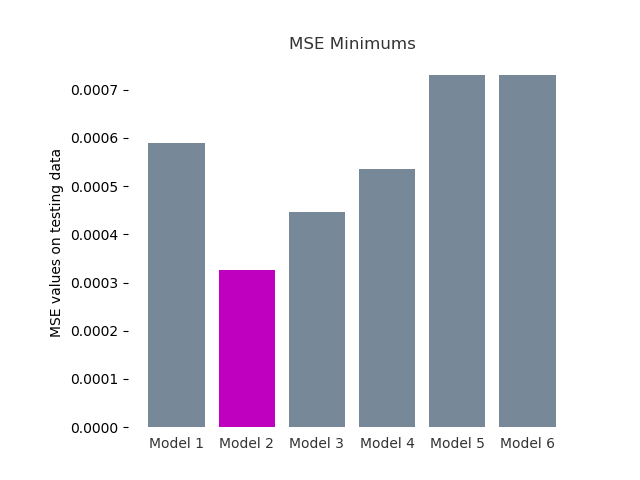

<IPython.core.display.Javascript object>


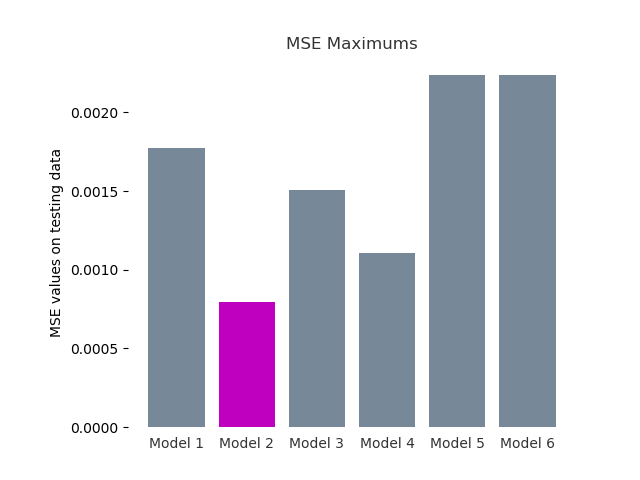

In [83]:
visualize_models_on_testing_data(all_test_mse_lists)

## Plot MSE for models on last 100 days

<IPython.core.display.Javascript object>


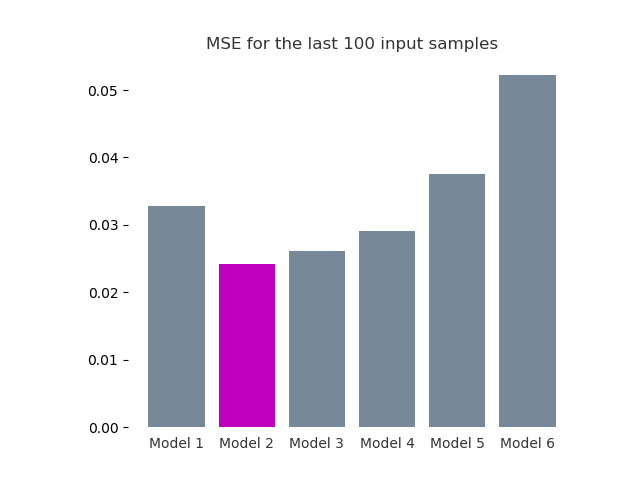

In [84]:
barplot(all_100_mse_list, x_ticks_labels, title='MSE for the last 100 input samples', 
        remove_ticks=True, remove_frame=True)

## Plot MSE for models on last 1000 days

<IPython.core.display.Javascript object>


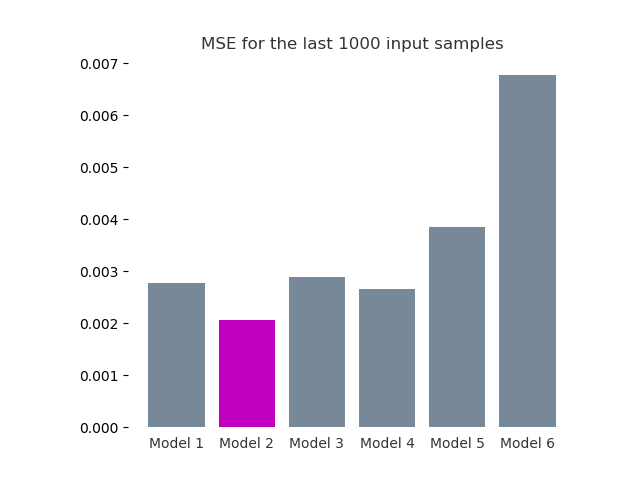

In [85]:
barplot(all_1000_mse_list, x_ticks_labels, title='MSE for the last 1000 input samples', 
        remove_ticks=True, remove_frame=True)

## Plot MSE for models on last 2000 days

<IPython.core.display.Javascript object>


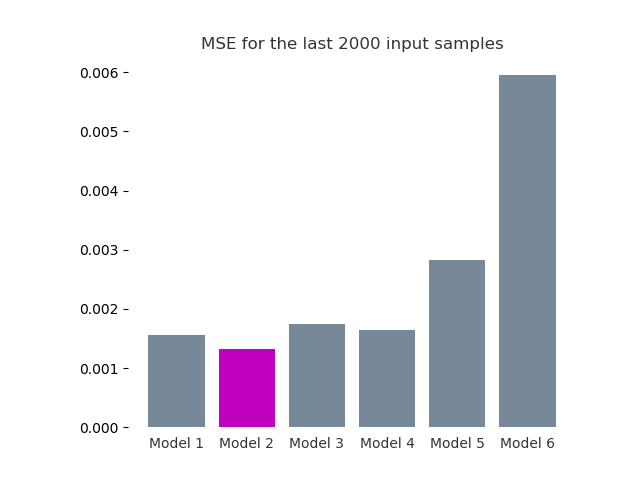

In [86]:
barplot(all_2000_mse_list, x_ticks_labels, title='MSE for the last 2000 input samples', 
        remove_ticks=True, remove_frame=True)

# Tabularly

Prepare the lists that are needed as parameters for the functions that will be used.

In [87]:
models = [model_100_70, model_100_50, model_1000_70, model_1000_50, model_2000_70, model_2000_50]
# Each sample for the last (100, 1000, and 2000) days:
X_test_lists = [X_test_sample_100, X_test_sample_1000, X_test_sample_2000]
y_test_lists = [y_test_sample_100, y_test_sample_1000, y_test_sample_2000]

In [88]:
models_names =  ['model_100_70','model_100_50','model_1000_70','model_1000_50','model_2000_70','model_2000_50']

In [89]:
mse_on_test_data = [ mse_list_100_70, mse_list_100_50, mse_list_1000_70, mse_list_1000_50, 
                    mse_list_2000_70, mse_list_2000_50]

## MSE on testing data

Evaluate each model's performance on each (X,y) pair of Numpy arrays (each generated with a different length of sequences) in the testing data.

In [103]:
mse_on_test_df = mse_on_testing_data_df(mse_on_test_data, models_names, lengths)
mse_on_test_df

,model_100_70,model_100_50,model_1000_70,model_1000_50,model_2000_70,model_2000_50
25,0.000591,0.000797,0.000550,0.000732,0.000967,0.000981
34,0.001325,0.000376,0.000555,0.000576,0.001102,0.001007
45,0.000596,0.000746,0.000556,0.000960,0.001810,0.001171
61,0.000888,0.000428,0.000550,0.000571,0.000752,0.001163
35,0.000656,0.000781,0.001507,0.000584,0.000983,0.001170
24,0.000811,0.000448,0.001323,0.000747,0.000913,0.001255
14,0.001771,0.000485,0.001386,0.001027,0.001073,0.002372
79,0.001278,0.000482,0.000522,0.001103,0.000962,0.001048
29,0.000774,0.000659,0.000579,0.000642,0.000899,0.001835
90,0.000853,0.000392,0.000766,0.001108,0.001603,0.001746


## MSE on the last samples

Evaluate each model's performance on each of the last 100, 1000 and 2000 days (totally unseen data).

In [91]:
mse_last_samples_df = mse_on_samples_df(models, X_test_lists, y_test_lists, 
                                        ['last_100_days','last_1000_days','last_2000_days'], models_names)
mse_last_samples_df

,model,last_100_days,last_1000_days,last_2000_days
0,model_100_70,0.032856,0.002766,0.001551
1,model_100_50,0.024191,0.002070,0.001318
2,model_1000_70,0.026081,0.002884,0.001737
3,model_1000_50,0.029103,0.002662,0.001650
4,model_2000_70,0.037577,0.003847,0.002822
5,model_2000_50,0.052195,0.006769,0.005951


# Saving the models

In [92]:
main_path = "E:\\Senior-Year  graduation project\\Latest results and models - 26-May-2019\\"

In [105]:
path_100_70 = "models - with validation\\model_100_70.h5"
path_100_50 = "models - with validation\\model_100_50.h5"

path_1000_70 = "models - with validation\\model_1000_70.h5"
path_1000_50 = "models - with validation\\model_1000_50.h5"

path_2000_70 = "models - with validation\\model_2000_70.h5"
path_2000_50 = "models - with validation\\model_2000_50.h5"

In [95]:
model_100_70.save(main_path+path_100_70)
model_100_50.save(main_path+path_100_50)

model_1000_70.save(main_path+path_1000_70)
model_1000_50.save(main_path+path_1000_50)

model_2000_70.save(main_path+path_2000_70)
model_2000_50.save(main_path+path_2000_50)

## Saving the resulted tables

In [107]:
mse_on_test_df.to_csv(main_path+"MSE tables (with validation)\\mse_on_testing_data.csv")
mse_last_samples_df.to_csv(main_path+"MSE tables (with validation)\\mse_on_last_samples.csv")